## **Algoritmos de Predição Aplicados a Dados de Vendas de uma Empresa de Ração** 
--------------------------------------------------------------------------------
###### @**Equipe: Francisco Douglas, Rogério Fernandes, Rafael Omega**.
  
- **1**: Dicionário dos Dados  
- **2**: Integração das bases de Dados  
- **3**: Pré-processamento dos dados  
- **4**: Tratamento e Manipulação dos Dados
- **5**: Analise dos Dados Pré-Processados
- **6**: Processamento Final
- **7**: Extração de Insights
- **8**: Modelos Series Temporais

## Importação das Bibliotecas

In [1]:
# Import Das Bibliotecas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

import plotly.graph_objects as go
import plotly.offline       as py
import plotly.express       as px
import scipy.stats          as stats

import statsmodels.tsa.stattools
from   matplotlib.pylab                   import rcParams
from   pandas_profiling                   import ProfileReport
from   sklearn.metrics                    import mean_absolute_error
from   sklearn.metrics                    import mean_squared_error
from   statsmodels.tsa.seasonal           import seasonal_decompose
from   statsmodels.graphics.tsaplots      import plot_acf, plot_pacf
from   statsmodels.tsa.arima.model        import ARIMA
from   pmdarima.arima                     import auto_arima
from   statsmodels.tsa.statespace.sarimax import SARIMAX
from   scipy.special                      import boxcox, inv_boxcox
from   scipy.stats                        import boxcox
from   sklearn.metrics                    import mean_absolute_percentage_error

sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 10,5

## Integração das Bases de Dados

In [2]:
# Importação das Bases de Dados
vendas       = pd.read_csv('dados_vendas.csv', sep=',', low_memory=False)
clientes     = pd.read_excel('clientes_vendedores.xlsm', sheet_name='CLIENTES')

## Pre-processamento dos dados

In [3]:
# Cabeçalho das bases de dados
display(vendas.head(3))
display(clientes.head(3))

COD_VENDA  SAT_NUMERO  COD_CLIENTE  COD_VENDEDOR        DATA      HORA  \
0   218562.0         NaN          2.0        2734.0  2017-03-17  09:22:40   
1   218632.0         NaN          2.0        2734.0  2017-03-17  09:22:41   
2   809262.0         NaN          2.0        3640.0  2017-09-04  17:27:30   

  COD_PRODUTO                                  DESC_PRODUTO  QTD  PRECO_CUSTO  \
0       42562  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
1       42562  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
2       59933             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   

   CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO  
0        13.99        14.00       14.00  
1        13.99        14.00       14.00  
2        10.84        10.85       10.85

COD_CLIENTE      CLIENTE  EMAIL    SETOR                         ENDERECO  \
0            2  CLIENTE - 2    NaN  SETOR 2  RUA ANTONIO FERREIRA DE ALMEIDA   
1            4  CLIENTE - 4    NaN  SETOR 2             RUA SETE DE SETEMBRO   
2            6  CLIENTE - 6    NaN  SETOR 2                        PRIMAVERA   

  NUMERO COMPLEMENTO        BAIRRO       CEP        MUNICIPIO  UF  
0    333         NaN        CENTRO  12980000       JOANOPOLIS  SP  
1    244      SALA 5        CENTRO  12970000         PIRACAIA  SP  
2    790         NaN  VILA BELMIRA  07863090  FRANCO DA ROCHA  SP

In [4]:
# Shape das Bases de dados
print(f'Base de Vendas: {vendas.shape[0]} Linhas e {vendas.shape[1]} Colunas')
print(f'Base de Clientes: {clientes.shape[0]} Linhas e {clientes.shape[1]} Colunas')

Base de Vendas: 1106185 Linhas e 13 Colunas
Base de Clientes: 6028 Linhas e 11 Colunas


### Merge das Bases de Dados

In [5]:
# Colunas de Vendas
print("Colunas de Vendas: ",vendas.columns,'\n')
print("Colunas de Clientes: ", clientes.columns, '\n')

Colunas de Vendas:  Index(['COD_VENDA', 'SAT_NUMERO', 'COD_CLIENTE', 'COD_VENDEDOR', 'DATA',
       'HORA', 'COD_PRODUTO', 'DESC_PRODUTO', 'QTD', 'PRECO_CUSTO',
       'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO'],
      dtype='object') 

Colunas de Clientes:  Index(['COD_CLIENTE', 'CLIENTE', 'EMAIL', 'SETOR', 'ENDERECO', 'NUMERO',
       'COMPLEMENTO', 'BAIRRO', 'CEP', 'MUNICIPIO', 'UF'],
      dtype='object') 



#### Merge dos dados

In [6]:
# Merge dos Dados, Utilizando apenas as colunas que iremos trabalha
df_vendas = pd.merge(vendas[['COD_VENDA', 'SAT_NUMERO', 'COD_CLIENTE', 'COD_VENDEDOR', 'DATA', 'HORA', 
                             'COD_PRODUTO', 'DESC_PRODUTO','QTD', 'PRECO_CUSTO', 'CUSTO_TOTAL','VR_UNITARIO', 'VR_LIQUIDO']],
                   clientes[['COD_CLIENTE', 'SETOR', 'MUNICIPIO', 'UF']],
                   on='COD_CLIENTE', how='outer')
df_vendas.head()

COD_VENDA  SAT_NUMERO  COD_CLIENTE  COD_VENDEDOR        DATA      HORA  \
0   218562.0         NaN          2.0        2734.0  2017-03-17  09:22:40   
1   218632.0         NaN          2.0        2734.0  2017-03-17  09:22:41   
2   809262.0         NaN          2.0        3640.0  2017-09-04  17:27:30   
3   809402.0         NaN          2.0        3640.0  2017-09-04  17:27:31   
4   920012.0         NaN          2.0        3640.0  2017-10-04  16:15:14   

  COD_PRODUTO                                  DESC_PRODUTO  QTD  PRECO_CUSTO  \
0       42562  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
1       42562  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
2       59933             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   
3       59933             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   
4       59933             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   

   CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR   MUNICIPIO  UF  
0        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP  
1        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP  
2        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP  
3        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP  
4        10.84        15.19       15.19  SETOR 2  JOANOPOLIS  SP

In [7]:
# Informações sobre os dados
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110655 entries, 0 to 1110654
Data columns (total 16 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   COD_VENDA     1091788 non-null  float64
 1   SAT_NUMERO    204706 non-null   float64
 2   COD_CLIENTE   1096258 non-null  float64
 3   COD_VENDEDOR  1091788 non-null  float64
 4   DATA          1091788 non-null  object 
 5   HORA          1091788 non-null  object 
 6   COD_PRODUTO   1106185 non-null  object 
 7   DESC_PRODUTO  1077957 non-null  object 
 8   QTD           1091788 non-null  float64
 9   PRECO_CUSTO   1091788 non-null  float64
 10  CUSTO_TOTAL   1091788 non-null  float64
 11  VR_UNITARIO   1091788 non-null  float64
 12  VR_LIQUIDO    1091788 non-null  float64
 13  SETOR         1096187 non-null  object 
 14  MUNICIPIO     1095407 non-null  object 
 15  UF            1094392 non-null  object 
dtypes: float64(9), object(7)
memory usage: 144.1+ MB


## Analise Exploratoria: Utilizando o Pandas Profiling

In [8]:
# Import da biblioteca
from pandas_profiling import ProfileReport

In [131]:
# Criando o Relatorio
#relatorio_vendas = ProfileReport(df_vendas, title='Relatorio de Vendas')
#relatorio_vendas.to_file('Relatorio_vendas.html')
#relatorio_vendas

##### Logo no Inicio com o Pandas-Profiling percebemos algums valores zeros e uma coluna com mais de 80% de NaN

**DF_VENDAS**
   **Colunas**
   - **SAT_NUMERO**: Quantidade NaN 81.6%
   - **PRECO_CUSTO**: Valores Negativos e Valores Zeros
   - **CUSTO_TOTAL**: Valores Negativos e Valores Zeros
   - **DEMAIS COLUNAS**: Valores NaN 18867

**Plot Grafico dos Dados NaN**

In [10]:
# Grafico Analise de Dados NaN
df = df_vendas.drop('SAT_NUMERO', axis=1)
null_df = df.isna().sum().reset_index()
data = [go.Bar(x=null_df['index'], y=null_df[0],
                   marker = {'color':null_df.index}, 
                   text=null_df[0], textposition='outside')]
configuracoes_layout = go.Layout(title='Contagem de Valores Nulos por coluna',
            yaxis={'title':'Quantidade de Valores NaN'}, xaxis={'title': 'Colunas'})
fig = go.Figure(data=data, layout=configuracoes_layout)
py.iplot(fig)

#### **Criando uma Função Para Calculo de Valores Ausentes por coluna**

In [11]:
# Função para calcular valores ausentes por coluna
def calc_nan(df):
    mis_val         = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_dtype   = df.dtypes
    mis_val_table   = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)
    ren_columns     = mis_val_table.rename(
    columns         = {0 : 'Valores Ausentes', 1 : '% de Valores Ausentes', 2: 'Dtype'})
    ren_columns     = ren_columns[ren_columns.iloc[:,0] != 0].sort_values('% de Valores Ausentes', ascending = False).round(2)
    print(f'O Dataframe tem ao todo: {df.shape[0]} Linhas e {df.shape[1]} Colunas.\n'
          f'Ao todo foram encontrados {ren_columns.shape[0]} Colunas com valores ausentes')
    if ren_columns.shape[0] == 0:
        return
    return ren_columns

In [12]:
# Calculo dos Valores Ausentes
calc_nan(df_vendas)

O Dataframe tem ao todo: 1110655 Linhas e 16 Colunas.
Ao todo foram encontrados 16 Colunas com valores ausentes


Valores Ausentes  % de Valores Ausentes    Dtype
SAT_NUMERO              905949                  81.57  float64
DESC_PRODUTO             32698                   2.94   object
COD_VENDA                18867                   1.70  float64
COD_VENDEDOR             18867                   1.70  float64
DATA                     18867                   1.70   object
HORA                     18867                   1.70   object
QTD                      18867                   1.70  float64
PRECO_CUSTO              18867                   1.70  float64
CUSTO_TOTAL              18867                   1.70  float64
VR_UNITARIO              18867                   1.70  float64
VR_LIQUIDO               18867                   1.70  float64
UF                       16263                   1.46   object
MUNICIPIO                15248                   1.37   object
SETOR                    14468                   1.30   object
COD_CLIENTE              14397                   1.30  float64
COD_PRODUTO               4470                   0.40   object

Percebemos que todas s Colunas estao com Valores NaN, algums valores NaN foram criados depois do nosso merge dos dados e outros que ja tinhamos, porem devemos primeiro analisa os Valores Negativos e Zeros para que assim depois damos sequencia no processamento e tratamento dos dados.

**Analise dos Valores Negativos e Zeros**

In [13]:
# Selecionando apenas as colunas CUSTO_TOTAL e PRECO_CUSTO que estao com valores 0 e Negativos
# Selecionaremos a Coluna VR_LIQUIDO para medimos o impacto nos dados de Vendas
df_vendas[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_LIQUIDO']].loc[(df_vendas['PRECO_CUSTO'] <= 0) & 
                                                            (df_vendas['CUSTO_TOTAL'] <= 0)]

PRECO_CUSTO  CUSTO_TOTAL  VR_LIQUIDO
3382           -0.02        -0.02        0.62
3383           -0.02        -0.02        0.63
3390           -0.02        -0.02        0.65
3391           -0.02        -0.02        0.65
3392           -0.02        -0.02        0.65
...              ...          ...         ...
1088890         0.00         0.00        8.33
1088891         0.00         0.00        8.33
1090801         0.00         0.00        0.01
1090802         0.00         0.00        0.14
1090841         0.00         0.00        0.09

[7025 rows x 3 columns]

**Analise do Impacto de valores Negativos e Zeros com o VR_LIQUIDO**

In [14]:
# Criando uma variavel de Valores Negativos
vr_negativos = df_vendas[['PRECO_CUSTO', 'CUSTO_TOTAL','VR_LIQUIDO']].loc[(df_vendas['PRECO_CUSTO'] <= 0) & 
                                                                    (df_vendas['CUSTO_TOTAL'] <= 0)]
vr_negativos = vr_negativos.VR_LIQUIDO.sum().round(3)
vr_negativos

116898.67

In [15]:
# Criando uma variavel do VR_LIQUIDO total dos dados
vr_liquido = df_vendas['VR_LIQUIDO'].sum().round(3)
vr_liquido

60197064.67

<font color='red'>**Percentual Equivalente, o quanto os dados negativos e zeros impactam com VR_LIQUIDO**

In [16]:
print(f'Representam: {(100 / vr_liquido) * vr_negativos:.5f}%')

Representam: 0.19419%


Percebemos que o impacto dos dados Negativos e Zeros com os dados de Vendas Representam um total de 0.19419% ou seja praticamento quase Zero

# Tratamento dos Dados

**Atribuindo valores NaN aos dados com valores Negativos e Zeros**

In [17]:
# Selecionando os valores acima de Zero, nesse caso os valores Negativos e Zeros iram retorna como NaN
df_vendas['PRECO_CUSTO'] = df_vendas.PRECO_CUSTO[df_vendas.PRECO_CUSTO > 0]
df_vendas['CUSTO_TOTAL'] = df_vendas.CUSTO_TOTAL[df_vendas.CUSTO_TOTAL > 0]

In [18]:
# Analisando Novamente se Temos Valores Negativos e Zeros
df_vendas[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_LIQUIDO']].loc[(df_vendas['PRECO_CUSTO'] <= 0) & 
                                                            (df_vendas['CUSTO_TOTAL'] <= 0)]

Empty DataFrame
Columns: [PRECO_CUSTO, CUSTO_TOTAL, VR_LIQUIDO]
Index: []

**Analise Grafica dos Valores Ausentes e NaN**

In [19]:
df = df_vendas.drop('SAT_NUMERO', axis=1)
null_df = df.isna().sum().reset_index()
data = [go.Bar(x=null_df['index'], y=null_df[0],
                   marker = {'color':null_df.index}, text=null_df[0], textposition='outside')]
configuracoes_layout = go.Layout(title='Contagem de Valores Nulos por coluna',
            yaxis={'title':'Quantidade de Valores NaN'}, xaxis={'title': 'Colunas'})
fig = go.Figure(data=data, layout=configuracoes_layout)
py.iplot(fig)

### <font color='red'>OBS:</font> 
- Perceba que varios valores NaN, foram criados depois do (Merge) dos dataframe
- Valores Negativos e Zeros temos ao todo 7025, oque levou a um resultado final de 25892 Valores NaN nas Colunas, (PRECO_CUSTO	CUSTO_TOTAL)
- Esses dados NaN serão dropados pois seu impacto no VR_LIQUIDO e Abaixo de 0.5%

In [20]:
# Utilizando a Funcao Calculo dos Valores Ausentes
calc_nan(df_vendas)

O Dataframe tem ao todo: 1110655 Linhas e 16 Colunas.
Ao todo foram encontrados 16 Colunas com valores ausentes


Valores Ausentes  % de Valores Ausentes    Dtype
SAT_NUMERO              905949                  81.57  float64
DESC_PRODUTO             32698                   2.94   object
PRECO_CUSTO              25892                   2.33  float64
CUSTO_TOTAL              25892                   2.33  float64
COD_VENDA                18867                   1.70  float64
COD_VENDEDOR             18867                   1.70  float64
DATA                     18867                   1.70   object
HORA                     18867                   1.70   object
QTD                      18867                   1.70  float64
VR_UNITARIO              18867                   1.70  float64
VR_LIQUIDO               18867                   1.70  float64
UF                       16263                   1.46   object
MUNICIPIO                15248                   1.37   object
SETOR                    14468                   1.30   object
COD_CLIENTE              14397                   1.30  float64
COD_PRODUTO               4470                   0.40   object

## Drop e Tratamento dos dados

In [21]:
# Removendo a coluna SAT_NUMERO e HORA pois não iremos utiliza-las
df_vendas.drop(['SAT_NUMERO', 'HORA'], axis=1, inplace=True)

In [22]:
# Removendo todos os dados nulos
df_vendas.dropna(axis=0, inplace=True)

In [23]:
# Shape dos Dados (Depois) da remoção de todos os NaN
print(f'Colunas: {df_vendas.shape[1]}, Linhas: {df_vendas.shape[0]}')

Colunas: 14, Linhas: 1057387


In [24]:
print('Foi Removido 1 Coluna SAT_NUMERO com mais de 80% de NaN')
print(f'Ao todo Foram Removidas: {1091788  - 1083801} Linhas NaN do DataFrame')
print(f'Que Representam: {(100 / 1091788 ) * 7987 :.2f}% das Linhas')

Foi Removido 1 Coluna SAT_NUMERO com mais de 80% de NaN
Ao todo Foram Removidas: 7987 Linhas NaN do DataFrame
Que Representam: 0.73% das Linhas


In [25]:
# Utilizando a Funcao Calculo dos Valores Ausentes
calc_nan(df_vendas)

O Dataframe tem ao todo: 1057387 Linhas e 14 Colunas.
Ao todo foram encontrados 0 Colunas com valores ausentes


OBS:

        Porque Removemos todos os dados Nulos e Zeros/Negativos ??

Devido temos um total de 15000 produtos com precos diferentes, não teria como fazer o tratamento dos valores NaN e no final termos um resultado rasoavel com o VR_LIQUIDO, poderiamos ter dados desbalanceados ou mesmos incoerentes com os dados reais, nesse caso devido ao impacto ser abaixo de 0.3% resolvemos dropa todos os NaN

### Conversão dos tipos de dados

In [26]:
%%time
df_vendas['DATA'] = pd.to_datetime(df_vendas['DATA'], format='%Y/%m/%d')
df_vendas['DATA'] = pd.to_datetime(df_vendas['DATA']).dt.normalize()
df_vendas['COD_VENDEDOR'] = df_vendas['COD_VENDEDOR'].astype('str')

CPU times: total: 656 ms
Wall time: 1.39 s


In [27]:
# Tipo dos dados
df_vendas.dtypes

COD_VENDA              float64
COD_CLIENTE            float64
COD_VENDEDOR            object
DATA            datetime64[ns]
COD_PRODUTO             object
DESC_PRODUTO            object
QTD                    float64
PRECO_CUSTO            float64
CUSTO_TOTAL            float64
VR_UNITARIO            float64
VR_LIQUIDO             float64
SETOR                   object
MUNICIPIO               object
UF                      object
dtype: object

In [28]:
# Criando a Nova Variavel MARGEM_LUCRO
df_vendas['MARGEM_LUCRO'] = round(df_vendas['VR_LIQUIDO'] - df_vendas['CUSTO_TOTAL'], 3)
df_vendas.head()

COD_VENDA  COD_CLIENTE COD_VENDEDOR       DATA COD_PRODUTO  \
0   218562.0          2.0       2734.0 2017-03-17       42562   
1   218632.0          2.0       2734.0 2017-03-17       42562   
2   809262.0          2.0       3640.0 2017-09-04       59933   
3   809402.0          2.0       3640.0 2017-09-04       59933   
4   920012.0          2.0       3640.0 2017-10-04       59933   

                                   DESC_PRODUTO  QTD  PRECO_CUSTO  \
0  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
1  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
2             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   
3             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   
4             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   

   CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR   MUNICIPIO  UF  MARGEM_LUCRO  
0        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP          0.01  
1        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP          0.01  
2        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP          0.01  
3        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP          0.01  
4        10.84        15.19       15.19  SETOR 2  JOANOPOLIS  SP          4.35

# Analise Exploratoria dos Dados Pre-Processamento

In [29]:
# Decrição estatistica dos dados
df_vendas.describe().round(2)

COD_VENDA  COD_CLIENTE         QTD  PRECO_CUSTO  CUSTO_TOTAL  \
count  1057387.00   1057387.00  1057387.00   1057387.00   1057387.00   
mean   1626581.23       409.10        2.73        13.36        41.23   
std    1444556.04      1051.72        7.77        18.94       164.56   
min          3.00         2.00        0.03         0.01         0.01   
25%     118504.50         2.00        1.00         2.38         3.12   
50%    1392102.00         2.00        1.00         6.30         7.79   
75%    2908752.00       591.00        2.00        19.43        25.83   
max    4373062.00     12962.00      500.00      3796.65     18886.00   

       VR_UNITARIO  VR_LIQUIDO  MARGEM_LUCRO  
count   1057387.00  1057387.00    1057387.00  
mean         19.43       55.46         14.22  
std          26.84      207.26         49.01  
min           0.14        0.28       -394.52  
25%           4.22        5.32          2.20  
50%          10.07       12.74          4.76  
75%          27.30       37.45         11.25  
max        5425.00    22680.00       7322.00

In [30]:
# Correlação de Spearman dos dados
df_vendas.corr('spearman').round(3)

COD_VENDA  COD_CLIENTE    QTD  PRECO_CUSTO  CUSTO_TOTAL  \
COD_VENDA         1.000       -0.033 -0.012       -0.063       -0.058   
COD_CLIENTE      -0.033        1.000  0.324        0.318        0.418   
QTD              -0.012        0.324  1.000        0.003        0.363   
PRECO_CUSTO      -0.063        0.318  0.003        1.000        0.913   
CUSTO_TOTAL      -0.058        0.418  0.363        0.913        1.000   
VR_UNITARIO      -0.075        0.303 -0.022        0.986        0.890   
VR_LIQUIDO       -0.068        0.417  0.379        0.894        0.988   
MARGEM_LUCRO     -0.076        0.391  0.387        0.828        0.929   

              VR_UNITARIO  VR_LIQUIDO  MARGEM_LUCRO  
COD_VENDA          -0.075      -0.068        -0.076  
COD_CLIENTE         0.303       0.417         0.391  
QTD                -0.022       0.379         0.387  
PRECO_CUSTO         0.986       0.894         0.828  
CUSTO_TOTAL         0.890       0.988         0.929  
VR_UNITARIO         1.000       0.894         0.856  
VR_LIQUIDO          0.894       1.000         0.969  
MARGEM_LUCRO        0.856       0.969         1.000

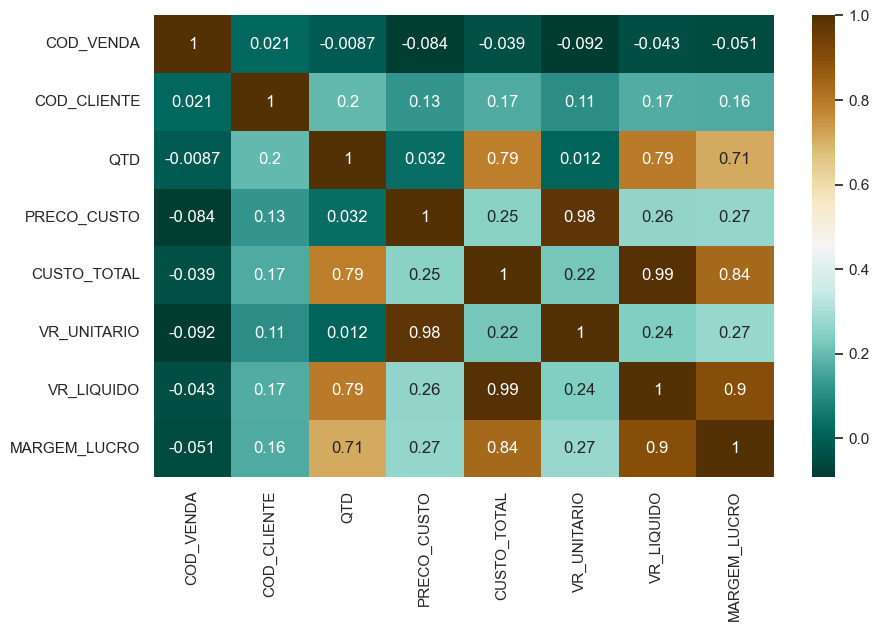

In [31]:
# Heatmap de Correlação
plt.figure(figsize = (10, 6))
sns.heatmap(df_vendas.corr(), annot=True, cmap='BrBG_r');

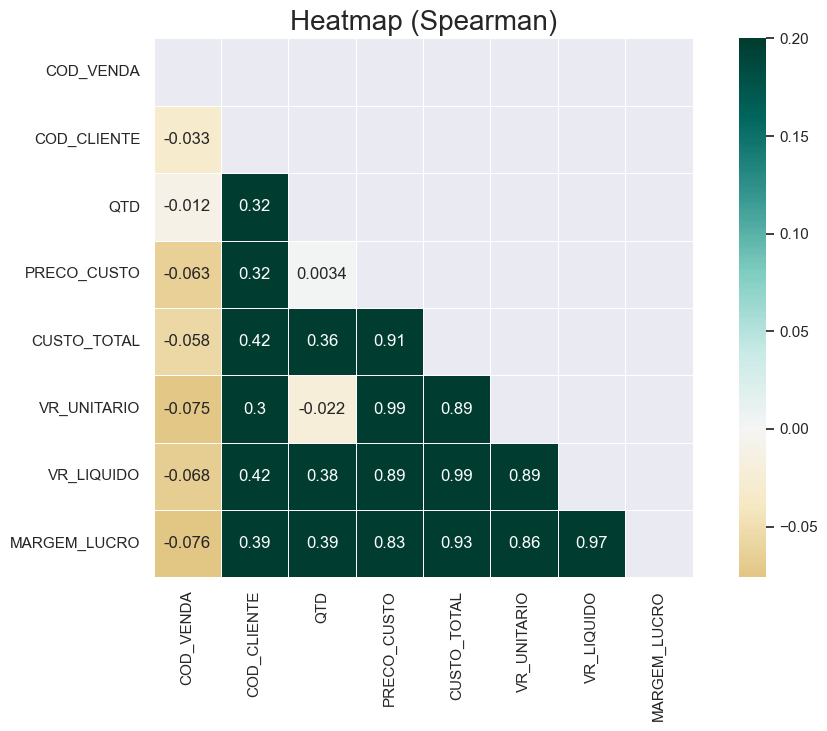

In [32]:
# Heatmap de Correlação (Spearman)
plt.figure(figsize=(12, 7))
corr = df_vendas.corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.title('Heatmap (Spearman)', fontsize=20)
sns.heatmap(corr, mask=mask, vmax=0.2, center=0, square=True, linewidth=.5, annot=True, cmap='BrBG');

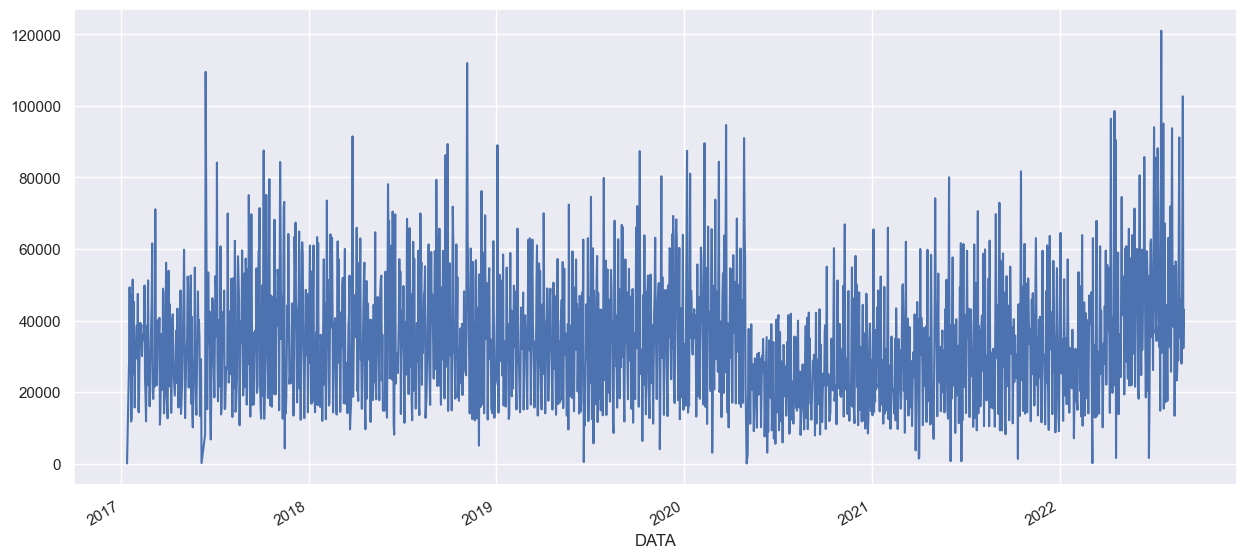

In [33]:
# Grafico de Linhas, Dados Agrupados diario
df = df_vendas.groupby('DATA').VR_LIQUIDO.sum()
plt.figure(figsize=(15, 7))
df.plot();

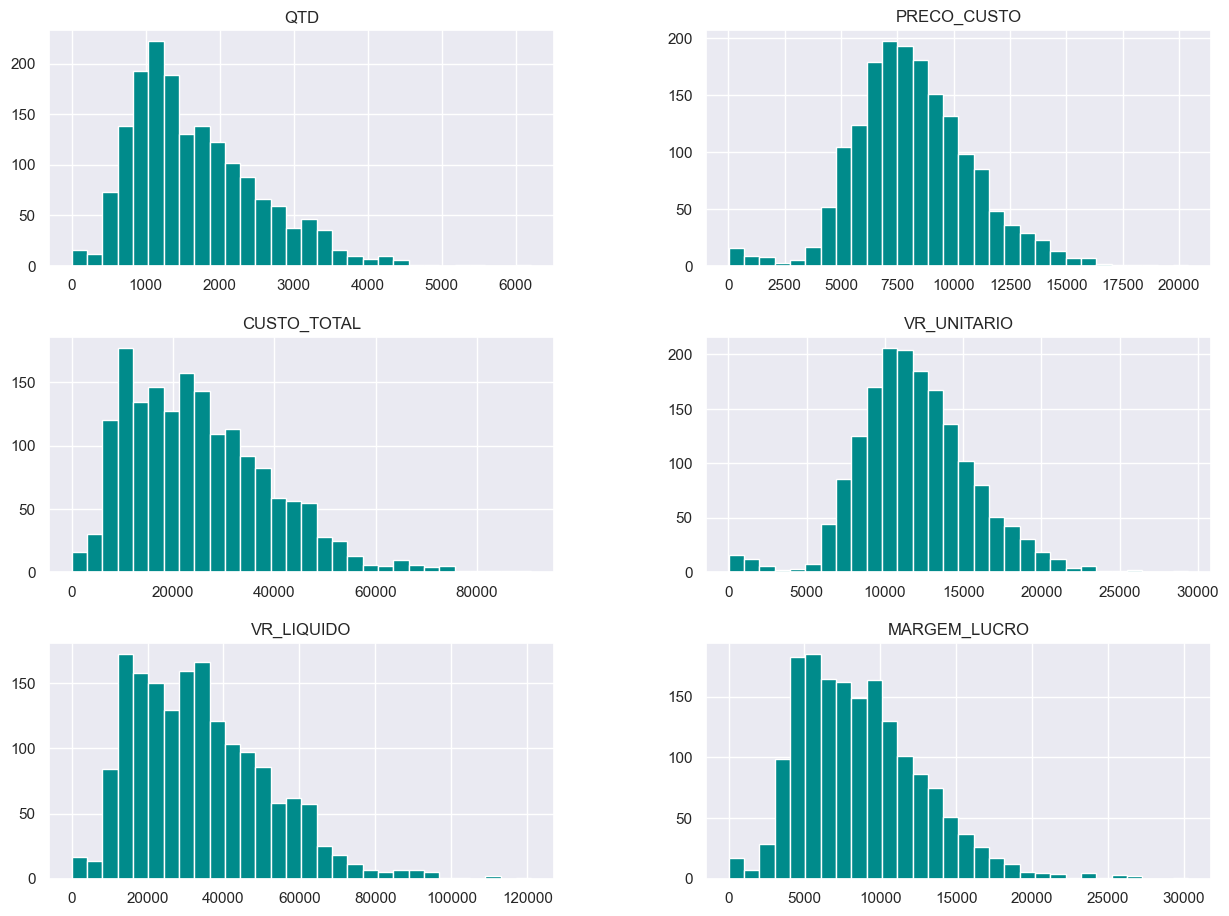

In [34]:
# Histograma apenas das colunas selecionadas, iremos agrupa os dados pelo periodo diario
df = df_vendas.groupby("DATA")[['QTD', 'DATA','PRECO_CUSTO', 'CUSTO_TOTAL', 
                             'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']].sum()
df.hist(figsize=(15, 15), layout=(4,2), color = 'darkcyan', bins=30);

**Criando uma copia do DataFrame**

In [35]:
# Criando uma copia
df_resp = df_vendas.copy()

# Atribuindo a Coluna Data como Index
df_resp.set_index("DATA", inplace=True)

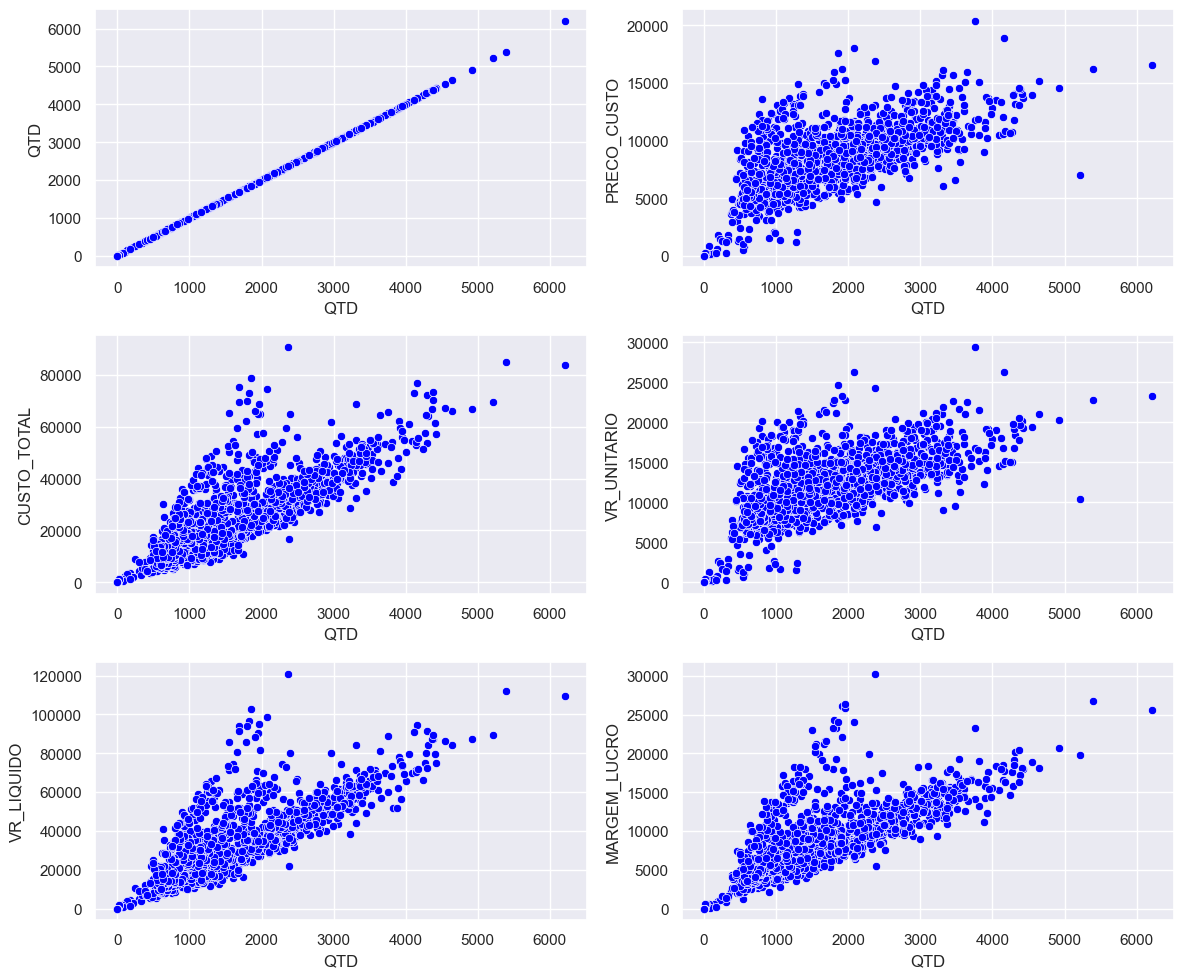

In [36]:
# Analise Grafica. Dispersão da Variavel QTD
df_rp = df_resp.resample('D').sum()
colunas = ['QTD','PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']
plt.figure(figsize=(12,16))
for k in range(len(colunas)):
    plt.subplot(5,2, k+1)
    sns.scatterplot(x='QTD', y=colunas[k], data=df_rp,color='blue')
    plt.ylabel(colunas[k],fontsize=12)
    plt.xlabel('QTD',fontsize=12)
plt.tight_layout();

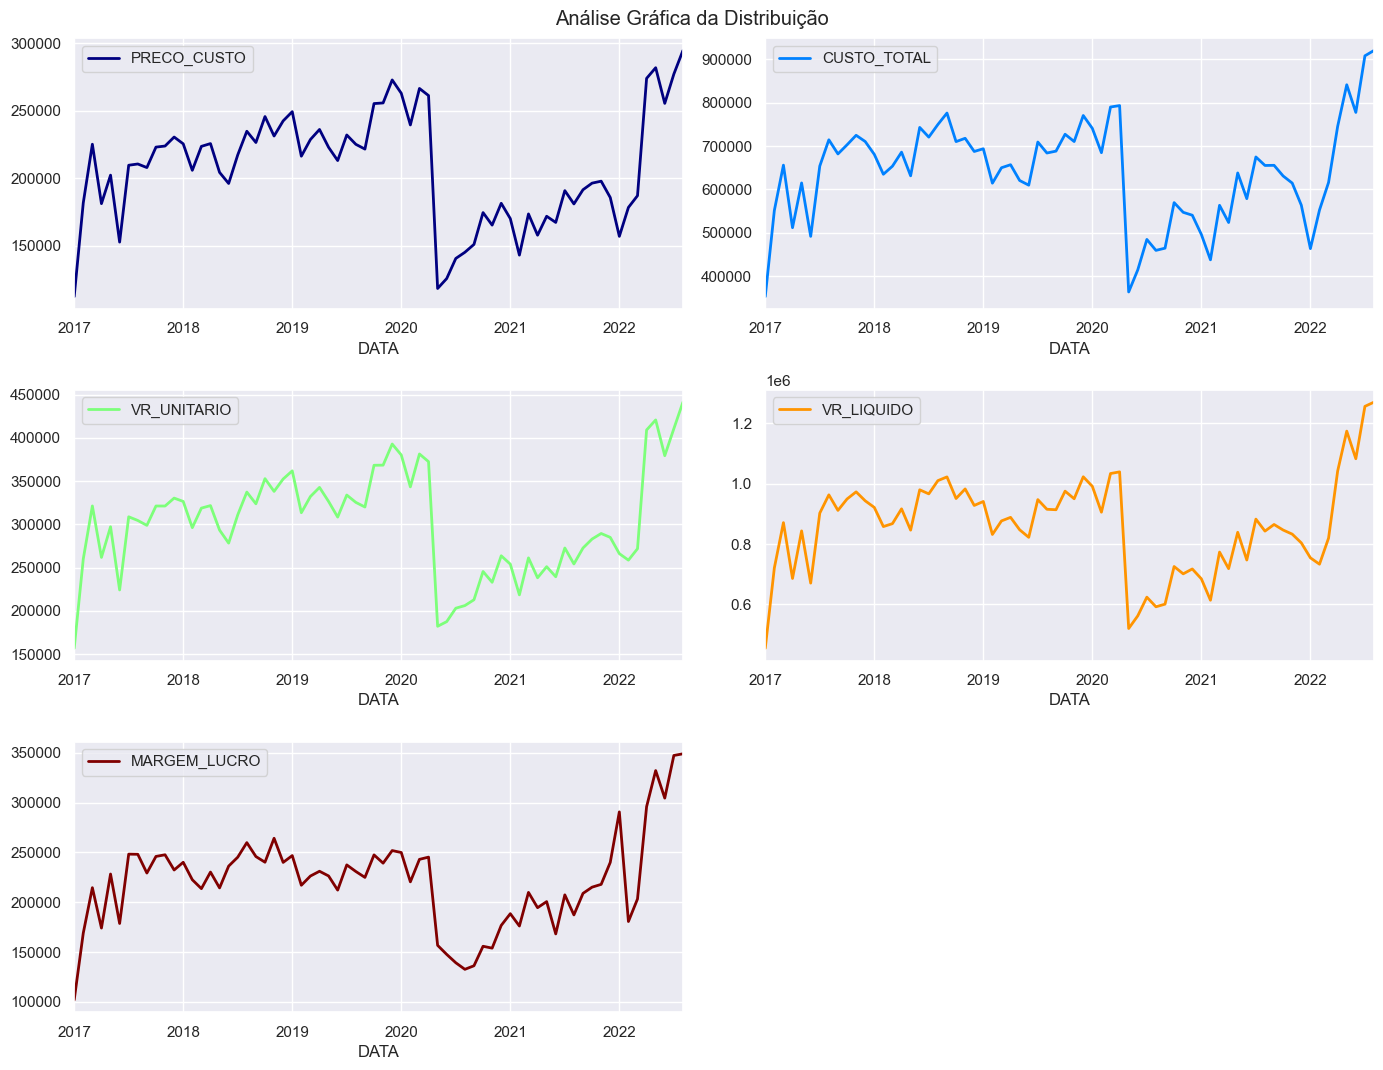

In [37]:
# Analise Grafica: Comportamento dos Dados Periodo Mensal
df = df_resp.resample('M').sum()
df.iloc[:,3:14].plot(subplots=True, layout=(4, 2), figsize=(14, 14), linewidth = 2.0,
                       cmap = 'jet', sharex=False, title = 'Análise Gráfica da Distribuição')
plt.tight_layout();

In [38]:
# Boxplot: Analise de Outliers
df = df_resp[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']]
dados = df.resample("D").sum()
fig = px.box(dados)
fig.show();

In [39]:
# Analisandos os dados de outliers
df = df_vendas[['COD_VENDA', 'COD_CLIENTE', 'COD_VENDEDOR', 'DATA','COD_PRODUTO', 'QTD', 'PRECO_CUSTO', 
                'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'SETOR', 'MUNICIPIO', 'UF', 'MARGEM_LUCRO']].loc[(df_vendas['VR_LIQUIDO'] > 2000)]
df[:4]

COD_VENDA  COD_CLIENTE COD_VENDEDOR       DATA COD_PRODUTO    QTD  \
219005  4198542.0          2.0         51.0 2020-03-12         452  100.0   
219006  4198572.0          2.0         51.0 2020-03-12         452  100.0   
458350  1433312.0          2.0         47.0 2018-02-20           6  100.0   
458351  1434272.0          2.0         47.0 2018-02-20           6  100.0   

        PRECO_CUSTO  CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR  \
219005        22.10       2209.9        27.65      2765.0  SETOR 2   
219006        22.10       2209.9        27.65      2765.0  SETOR 2   
458350        21.55       2155.3        30.66      3066.0  SETOR 2   
458351        21.55       2155.3        30.66      3066.0  SETOR 2   

         MUNICIPIO  UF  MARGEM_LUCRO  
219005  JOANOPOLIS  SP         555.1  
219006  JOANOPOLIS  SP         555.1  
458350  JOANOPOLIS  SP         910.7  
458351  JOANOPOLIS  SP         910.7

In [40]:
# Grafico de Linha: Variaveis PRECO_CUSTO, CUSTO_TOTAL, VR_LIQUIDO, MARGEM_LUCRO
db = df_resp.resample('M').sum()
db.reset_index(inplace=True)
fig = px.line(db, x='DATA', y=['PRECO_CUSTO','CUSTO_TOTAL','VR_LIQUIDO','MARGEM_LUCRO'], markers=True, height=600,
             title='Comportamento dos Dados ao Longo do Tempo')
fig.update_traces(textposition="bottom right")
fig.show()

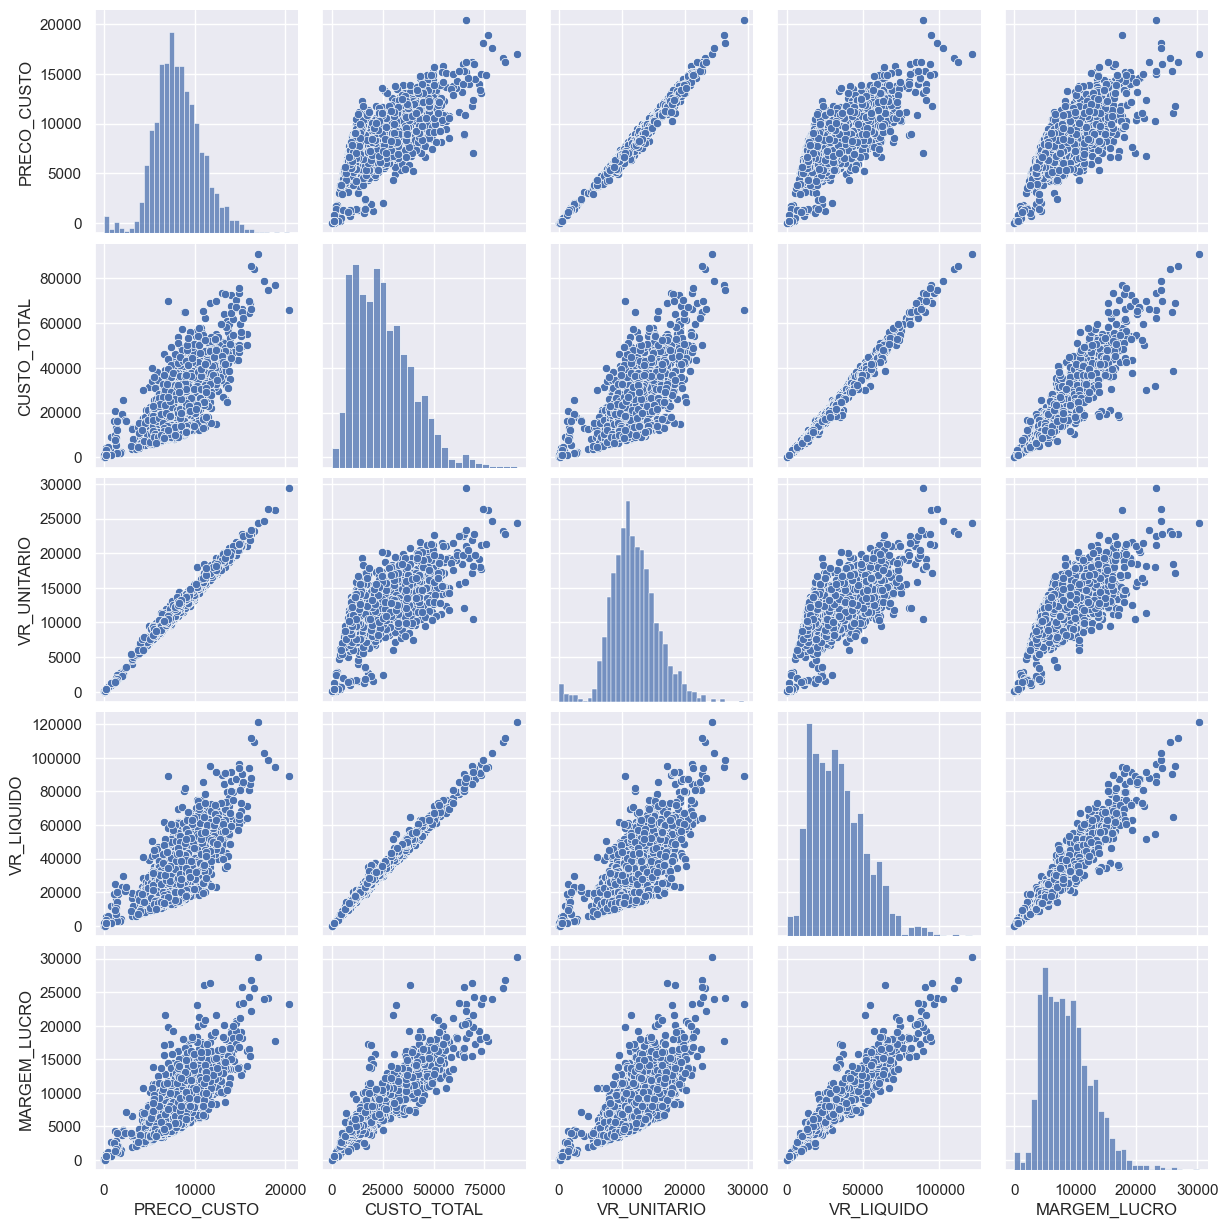

In [41]:
# Plotando várias distribuições bivariadas de pares no nosso conjunto de dados,
df = df_resp[['PRECO_CUSTO', 'CUSTO_TOTAL', 'VR_UNITARIO', 'VR_LIQUIDO', 'MARGEM_LUCRO']]
df_rp = df.groupby('DATA').sum()
sns.pairplot(df_rp, );

In [42]:
df_rp = df_resp.resample('D').sum()
#df_rp = df_vendas.groupby('DATA').sum()
fig = px.scatter(df_rp, x="VR_LIQUIDO", y="VR_UNITARIO", trendline="ols")
fig.show()

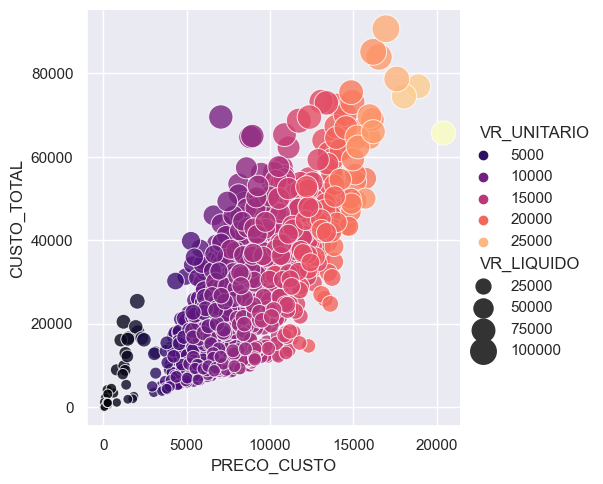

In [43]:
df_rp = df_vendas.groupby('DATA').sum()
sns.relplot(x='PRECO_CUSTO', y='CUSTO_TOTAL', hue='VR_UNITARIO', data=df_rp, size='VR_LIQUIDO',
            sizes=(40,400), alpha=0.8, palette='magma');

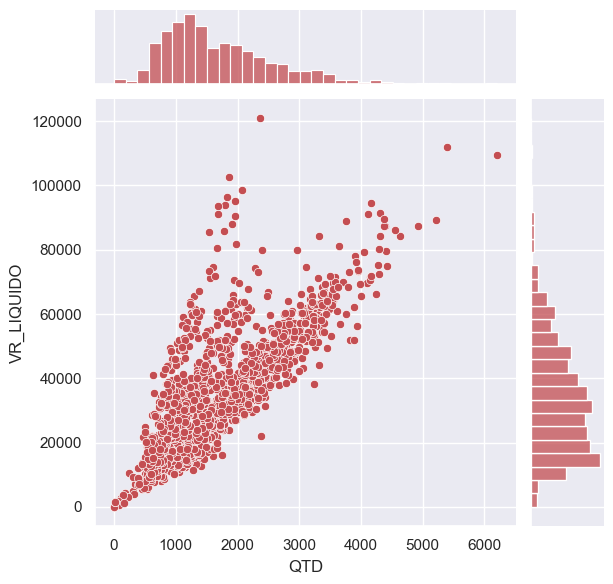

In [44]:
df_rp = df_vendas.groupby('DATA').sum()
sns.jointplot(x='QTD', y='VR_LIQUIDO', color='r', data=df_rp);

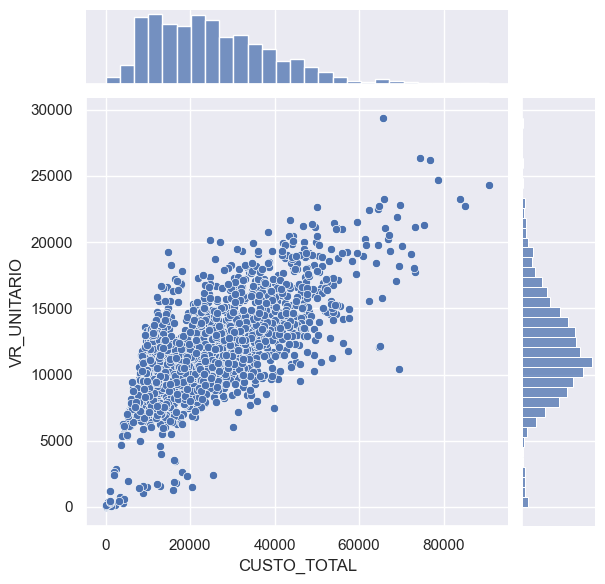

In [45]:
df_rp = df_vendas.groupby('DATA').sum()
sns.jointplot(x='CUSTO_TOTAL', y='VR_UNITARIO', data=df_rp);

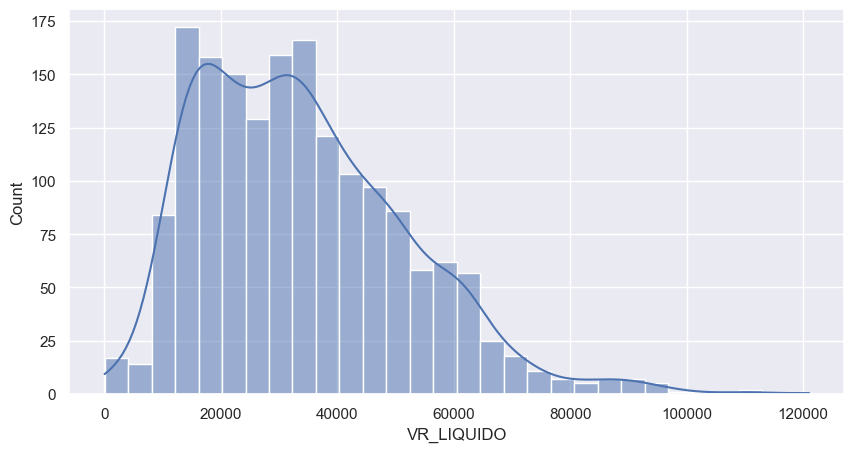

In [46]:
# Distribuição dos dados
plt.figure(figsize=(10,5))
sns.histplot(df_rp.VR_LIQUIDO, bins=30, color='b', kde=True);

# Processamento Final

In [47]:
# Criando uma Nova Variavel ANO_MES
df_vendas['ANO_MES'] = df_vendas['DATA'].apply(lambda x: str(x)[:7])

**Adicionando Algums nomes aleatorios para o Codigo do Vendedor**

In [48]:
# Cabeçalho
df_vendas.head()

COD_VENDA  COD_CLIENTE COD_VENDEDOR       DATA COD_PRODUTO  \
0   218562.0          2.0       2734.0 2017-03-17       42562   
1   218632.0          2.0       2734.0 2017-03-17       42562   
2   809262.0          2.0       3640.0 2017-09-04       59933   
3   809402.0          2.0       3640.0 2017-09-04       59933   
4   920012.0          2.0       3640.0 2017-10-04       59933   

                                   DESC_PRODUTO  QTD  PRECO_CUSTO  \
0  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
1  COMEDOURO P/ AVES AVIPET ALUMINIO CONICO 2KG  1.0        13.99   
2             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   
3             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   
4             AREIA MICRO SILICA THE CATS 1,6KG  1.0        10.84   

   CUSTO_TOTAL  VR_UNITARIO  VR_LIQUIDO    SETOR   MUNICIPIO  UF  \
0        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP   
1        13.99        14.00       14.00  SETOR 2  JOANOPOLIS  SP   
2        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP   
3        10.84        10.85       10.85  SETOR 2  JOANOPOLIS  SP   
4        10.84        15.19       15.19  SETOR 2  JOANOPOLIS  SP   

   MARGEM_LUCRO  ANO_MES  
0          0.01  2017-03  
1          0.01  2017-03  
2          0.01  2017-09  
3          0.01  2017-09  
4          4.35  2017-10

# Insights de Negocios

    1. Quais os meses do ano houve mais vendas?
    2. Quais as cidades que mais compram
    3. Como foi as vendas por mês
    4. Quais Vendedores Mais Vendem?
    5. Quais Produtos Mais Vendem?
    6. Quais Produtos Geram maior receita?
    7. Existe Algum cliente que gera maior receita?
    8. As vendas estão crescendo a cada ano?

**1. Quais os meses do ano houve mais vendas?**

In [49]:
# Separando apenas os meses a quantidade e o valor liquido
meses_maior_vendas = df_vendas[['QTD','DATA','ANO_MES','VR_LIQUIDO']].groupby('ANO_MES')[['VR_LIQUIDO','QTD']].sum()
meses = meses_maior_vendas.sort_values(by='VR_LIQUIDO', ascending=False)
meses.reset_index(inplace=True)

In [50]:
# Separando os Meses de Cada Ano
meses_2017 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2017-01') & (meses['ANO_MES'] <= '2017-12')]
meses_2018 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2018-01') & (meses['ANO_MES'] <= '2018-12')]
meses_2019 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2019-01') & (meses['ANO_MES'] <= '2019-12')]
meses_2020 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2020-01') & (meses['ANO_MES'] <= '2020-12')]
meses_2021 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2021-01') & (meses['ANO_MES'] <= '2021-12')]
meses_2022 = meses[['ANO_MES','QTD','VR_LIQUIDO']].loc[(meses['ANO_MES'] >= '2022-01') & (meses['ANO_MES'] <= '2022-12')]

In [51]:
# Selecionando apenas os 4 Maiores meses de vendas de cada ano
meses2017 = meses_2017.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2018 = meses_2018.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2019 = meses_2019.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2020 = meses_2020.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2021 = meses_2021.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
meses2022 = meses_2022.sort_values(by='VR_LIQUIDO', ascending=False)[:4]
total_meses = pd.concat([meses2017, meses2018, meses2019, meses2020, meses2021, meses2022])
len(total_meses)

24

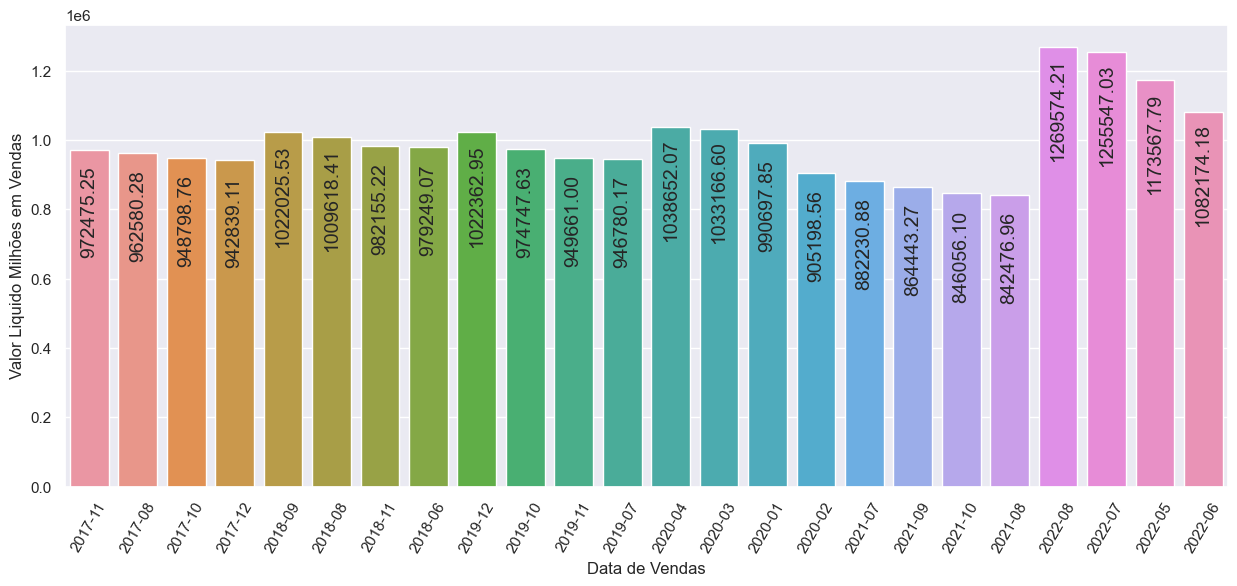

In [52]:
# Maiores Meses onde Ocorreram mais Vendas
#maiores_meses.reset_index(inplace=True)
sns.set(font_scale = 1)
plt.figure(figsize = (15, 6))
plots = sns.barplot(x = 'ANO_MES',  y='VR_LIQUIDO', data=total_meses)
for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', 
                   size=14, xytext=(0, -45),  textcoords='offset points', rotation=90)
plt.xlabel('Data de Vendas')
plt.ylabel('Valor Liquido Milhões em Vendas')
plt.xticks(rotation = 60);

**2. Quais as cidades que mais compram**

In [53]:
cidades_mais_compram = df_vendas[['QTD','DATA','VR_LIQUIDO','MUNICIPIO',
                                  'UF','ANO_MES']].groupby(['MUNICIPIO','UF'])[['VR_LIQUIDO']].sum()
cidades_mais_compram = cidades_mais_compram.sort_values(by='VR_LIQUIDO', ascending=False)[:15]
cidades_mais_compram.reset_index(inplace=True)
cidades_mais_compram

MUNICIPIO  UF   VR_LIQUIDO
0              JOANOPOLIS  SP  26756117.83
1         NAZARE PAULISTA  SP   4231679.49
2                 EXTREMA  MG   3917891.06
3               SAO PAULO  SP   2804429.44
4               MAIRIPORA  SP   2433013.10
5                 ATIBAIA  SP   2143052.02
6               GUARULHOS  SP   2079075.86
7        FRANCISCO MORATO  SP   1539907.55
8                CAMPINAS  SP   1375396.89
9                 ITATIBA  SP   1178916.87
10               PIRACAIA  SP   1121224.54
11        FRANCO DA ROCHA  SP    768914.18
12        VARZEA PAULISTA  SP    700152.79
13  BOM JESUS DOS PERDOES  SP    576825.81
14            CAMANDUCAIA  MG    574089.16

In [54]:
# Plot grafico
fig = px.bar(cidades_mais_compram, x='MUNICIPIO', y='VR_LIQUIDO', text_auto='.4s',
            title="Cidades que Mais Compram na Empresa", color='VR_LIQUIDO', height=500)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**3. Como foi as vendas por mês**

In [55]:
vendas_mes = df_vendas.groupby('ANO_MES')[['VR_LIQUIDO','QTD','CUSTO_TOTAL','MARGEM_LUCRO']].sum()
vendas_mes.reset_index(inplace=True)
vendas_mes

ANO_MES  VR_LIQUIDO       QTD  CUSTO_TOTAL  MARGEM_LUCRO
0   2017-01   454508.04  24584.00    352569.11     101938.93
1   2017-02   720425.69  42461.00    551310.61     169115.08
2   2017-03   870542.16  51123.00    655900.07     214642.09
3   2017-04   685686.70  43619.00    511578.12     174108.58
4   2017-05   843200.18  50604.00    614837.68     228362.50
..      ...         ...       ...          ...           ...
63  2022-04  1041384.30  24918.18    745407.35     295976.95
64  2022-05  1173567.79  27058.64    841356.08     332211.71
65  2022-06  1082174.18  24375.97    777586.61     304587.57
66  2022-07  1255547.03  28057.94    908154.65     347392.38
67  2022-08  1269574.21  27154.91    920514.25     349059.96

[68 rows x 5 columns]

In [56]:
fig = px.bar(vendas_mes, x='ANO_MES', y=['VR_LIQUIDO','QTD'], color='QTD',
            title='Valor Liquido e Quantidade de Vendas no més', height=500,)
fig.show()

**4. Quais Vendedores Mais Vendem?**

In [57]:
maiores_vendedores = df_vendas[['QTD','COD_VENDEDOR', 'VR_LIQUIDO', 'DATA']]
maiores_vendedores = maiores_vendedores.groupby("COD_VENDEDOR")[['VR_LIQUIDO','QTD']].sum()
maiores_vendedores = maiores_vendedores.sort_values(by='VR_LIQUIDO', ascending=False)[:10]
maiores_vendedores.reset_index(inplace=True)
maiores_vendedores

COD_VENDEDOR   VR_LIQUIDO        QTD
0        248.0  18152787.75  731861.85
1       3640.0   8375634.10  682169.00
2        238.0   3784327.23  144982.00
3         51.0   3215356.14  138560.57
4        498.0   3200746.22  129476.00
5          1.0   2879163.80  185076.92
6         47.0   2625187.23  154502.78
7         52.0   2420589.40   82661.88
8        250.0   1923873.22   87512.00
9         49.0   1467274.22   75810.93

In [58]:
maiores_vendedores.VR_LIQUIDO.sum()

48044939.31

In [59]:
fig = px.bar(maiores_vendedores, x='COD_VENDEDOR', y='VR_LIQUIDO', color='QTD', height=500, text_auto='.4s',
             title='Analise dos Maiores Que mais venderam ao longo do tempo')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**5. Quais Produtos Mais Vendem?**

In [60]:
produtos = df_vendas.groupby('DESC_PRODUTO')[['QTD','VR_LIQUIDO']].sum()
produtos = produtos.sort_values('QTD', ascending=False)[:15]
produtos.reset_index(inplace=True)
produtos

DESC_PRODUTO       QTD  VR_LIQUIDO
0              FARELO DE TRIGO 40 KG  192945.0  5476729.61
1                MILHO EM GRAOS 47KG  167474.0  6109886.22
2                  STYLO F. 20% 15KG  138668.0  2897515.84
3                STYLO F. 20% K 15KG  112964.0  2300269.22
4       SOPAO DE GATO (LUCK CAT) 1KG   72437.0   215611.62
5       SAL COMUM MOIDO C/ IODO 25KG   70891.0   684926.10
6              MUDAS DIVERSAS C/25UN   57852.0   154685.37
7                MILHO EM GRAOS 24KG   55052.0  1055622.26
8   AREIA P/GATO GRAN. MAZ CAT 6X4KG   53602.0   815107.07
9                   LUCK F. 18% 15KG   47751.0   841548.11
10                 TITAN F. 18% 15KG   45981.0   830808.65
11                MILHO EM GRAOS 5KG   41228.0   182471.41
12                    TITAN 18% 15KG   37784.0  1181064.00
13                QUIRERA S/PEN 40KG   27794.0   946260.15
14        PROEQUI 13 30KG C/LAMINADO   25443.0   900964.10

In [61]:
print(f'VR_LIQUIDO dos 15 Produtos Mais Vendidos: {produtos.VR_LIQUIDO.sum():.4f}R$')
print(f'VR_LIQUIDO Total de Vendas: {df_vendas.VR_LIQUIDO.sum():.4f}')

VR_LIQUIDO dos 15 Produtos Mais Vendidos: 24593469.7300R$
VR_LIQUIDO Total de Vendas: 58639799.8900


In [62]:
fig = px.bar(produtos, x='DESC_PRODUTO', y='QTD', color='QTD', height=500, text_auto='.4s',
             title='Produtos que Mais Vendem')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**6. Quais Produtos Geram maior receita?**

In [63]:
produtos_rc = df_vendas.groupby('DESC_PRODUTO')[['COD_PRODUTO','VR_LIQUIDO']].sum()
produtos_maior_rc = produtos_rc.sort_values('VR_LIQUIDO', ascending=False)[:14]
produtos_maior_rc.reset_index(inplace=True)
produtos_maior_rc

DESC_PRODUTO  VR_LIQUIDO
0                MILHO EM GRAOS 47KG  6109886.22
1              FARELO DE TRIGO 40 KG  5476729.61
2                  STYLO F. 20% 15KG  2897515.84
3                STYLO F. 20% K 15KG  2300269.22
4                     TITAN 18% 15KG  1181064.00
5                MILHO EM GRAOS 24KG  1055622.26
6                 QUIRERA S/PEN 40KG   946260.15
7         PROEQUI 13 30KG C/LAMINADO   900964.10
8                   LUCK F. 18% 15KG   841548.11
9       QUIRERA PENEIRADA MEDIO 40KG   837760.01
10                 TITAN F. 18% 15KG   830808.65
11  AREIA P/GATO GRAN. MAZ CAT 6X4KG   815107.07
12      SAL COMUM MOIDO C/ IODO 25KG   684926.10
13       QUIRERA PENEIRADA FINA 40KG   628894.81

In [64]:
fig = px.bar(produtos_maior_rc, x='DESC_PRODUTO', y='VR_LIQUIDO', color='VR_LIQUIDO', height=500, 
             text_auto='.4s', title='Produtos Mais Vendidos que geram maior receita')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

In [65]:
print('15 Produtos de Maior Receita', produtos_maior_rc.VR_LIQUIDO.sum())
print('VR_LIQUIDO', df_vendas.VR_LIQUIDO.sum())

15 Produtos de Maior Receita 25507356.15
VR_LIQUIDO 58639799.889999986


**7. Existe Algum cliente que gera maior receita?**

In [66]:
df_vendas['COD_CLIENTE'] = df_vendas['COD_CLIENTE'].astype('str')
clientes = df_vendas.groupby('COD_CLIENTE')[['QTD','VR_LIQUIDO']].sum()\
                            .sort_values('VR_LIQUIDO', ascending=False)[:15]
clientes.reset_index(inplace=True)
clientes

COD_CLIENTE       QTD   VR_LIQUIDO
0          2.0  954979.6  12111470.36
1       1060.0  118170.0   3045441.85
2        459.0   51236.0   1578302.09
3        517.0   60375.0   1445887.71
4        148.0   43771.0   1341566.44
5        696.0   66077.0   1303027.52
6        206.0   28411.0    748609.60
7        620.0   27001.0    718057.60
8        622.0   31453.0    708519.45
9        700.0   19789.0    649768.46
10       424.0   26418.0    570945.73
11       956.0   20401.0    556240.58
12      1426.0   18954.0    539992.24
13      1653.0   10457.0    456440.23
14       359.0   10199.0    435616.36

In [67]:
fig = px.bar(clientes, x=clientes['COD_CLIENTE'], y='VR_LIQUIDO', color='VR_LIQUIDO', 
             height=500, text_auto='.4s', title='Clientes que geram maior receita')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

**8. As vendas estão crescendo a cada ano?**

In [68]:
vendas_ano = df_vendas.groupby(df_vendas['DATA'].dt.year)[['VR_LIQUIDO','QTD']].sum()
vendas_ano.reset_index(inplace=True)
vendas_ano

DATA   VR_LIQUIDO        QTD
0  2017   9884530.56  598937.00
1  2018  11244480.28  650710.00
2  2019  10926768.76  624656.00
3  2020   9009430.80  457253.94
4  2021   9445951.35  344060.04
5  2022   8128638.14  211440.14

In [69]:
fig = px.bar(vendas_ano, x='DATA', y='VR_LIQUIDO', color='QTD',height=500,
            title='Vendas Por Ano', text_auto='.5s')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

Percebemos que ao longo do periodo de 2017 a Abril de 2020 as vendas vinham em uma linha crescente tendo algums picos entre os meses de Junho a Dezembro, porem tivemos um Pico de Queda no més de Maior de 2020, onde no mesmo més foi declarado Lockdown no Brasil COVID-19 https://pt.wikipedia.org/wiki/Lockdown_no_Brasil_em_2021, levando a mais de 8 meses de queda nas vendas. Logo no inicio de Marco 2021, temos começa uma crescente alta nas vendas alcançando seu pico maximo nos méses de Abril a Junho de 2022

# Analise de Séries Temporais:

## **<font color='blue'>Modelos: AUTO_ARIMA, SARIMAX</font>**

In [70]:
# Selecionando apenas as coluna DATA e VR_LIQUIDO e agrupando por periodo diario
dados = df_vendas[['DATA','VR_LIQUIDO']].groupby(['DATA']).sum()
dados.reset_index(inplace=True)
df = dados[['DATA','VR_LIQUIDO']]
print('Utilizando', len(df), 'Valores')

Utilizando 1723 Valores


In [130]:
df_vendas.to_csv("dados_tratados.csv", index=False)

In [71]:
dados_serie = df_vendas[['DATA','VR_LIQUIDO']].groupby(pd.Grouper(key='DATA', freq='6D')).sum()
dados_serie.reset_index(inplace=True)
dados_serie = dados_serie.copy()
dados_serie

DATA  VR_LIQUIDO
0   2017-01-12    78236.50
1   2017-01-18   149446.51
2   2017-01-24   154623.48
3   2017-01-30   178052.52
4   2017-02-05   183895.88
..         ...         ...
338 2022-08-02   226820.91
339 2022-08-08   298720.79
340 2022-08-14   204405.80
341 2022-08-20   242450.21
342 2022-08-26   234049.95

[343 rows x 2 columns]

In [72]:
# Atribuindo a Figura Grafica e Tamanho
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5

## **Análise e Preparação da Série**

### **Criando a Serie**

In [73]:
# Criando a serie
serie = pd.Series(dados_serie['VR_LIQUIDO'].values, index=dados_serie['DATA'].values)
print(serie)
type(serie)

2017-01-12     78236.50
2017-01-18    149446.51
2017-01-24    154623.48
2017-01-30    178052.52
2017-02-05    183895.88
                ...    
2022-08-02    226820.91
2022-08-08    298720.79
2022-08-14    204405.80
2022-08-20    242450.21
2022-08-26    234049.95
Length: 343, dtype: float64


pandas.core.series.Series

In [74]:
# Plot Grafico da Serie
fig = px.line(serie, x=serie.index, y=serie.values, title='Valores Serie Temporal', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### **Média Móvel**

In [75]:
media_movel = serie.rolling(window=5)
media_movel = media_movel.mean()
fig = px.line(media_movel, x=media_movel.index, y=media_movel.values, 
              title='Media Movel 5 Periodos', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [76]:
cores = ['red', 'blue','green']
data = [go.Scatter(x=serie.index, y=serie.values, marker = {'color': cores, 'line': {'color': '#333', 'width': 1}}, 
              opacity=1, name='Valores'),
        go.Scatter(x=media_movel.index, y=media_movel.values, name='Média', 
                   marker = {'color': 'green', 'line': {'color':'#333', 'width':1}}, opacity=0.7)]
# Criando Layout
config_layout = go.Layout(title='Comparação Serie_Real vs Media Movel 5 Periodos', 
                          yaxis={'title':'Valor Liquido'}, xaxis={'title':'Periodo'}, height=600)
# Objeto Figura
fig = go.Figure(data=data, layout=config_layout)
fig.update_xaxes(rangeslider_visible=True)
py.iplot(fig)

**Decomposição dos Dados**

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Analisando os ultimos 500 Periodos
decomposicao = seasonal_decompose(serie[-500:], period=7)

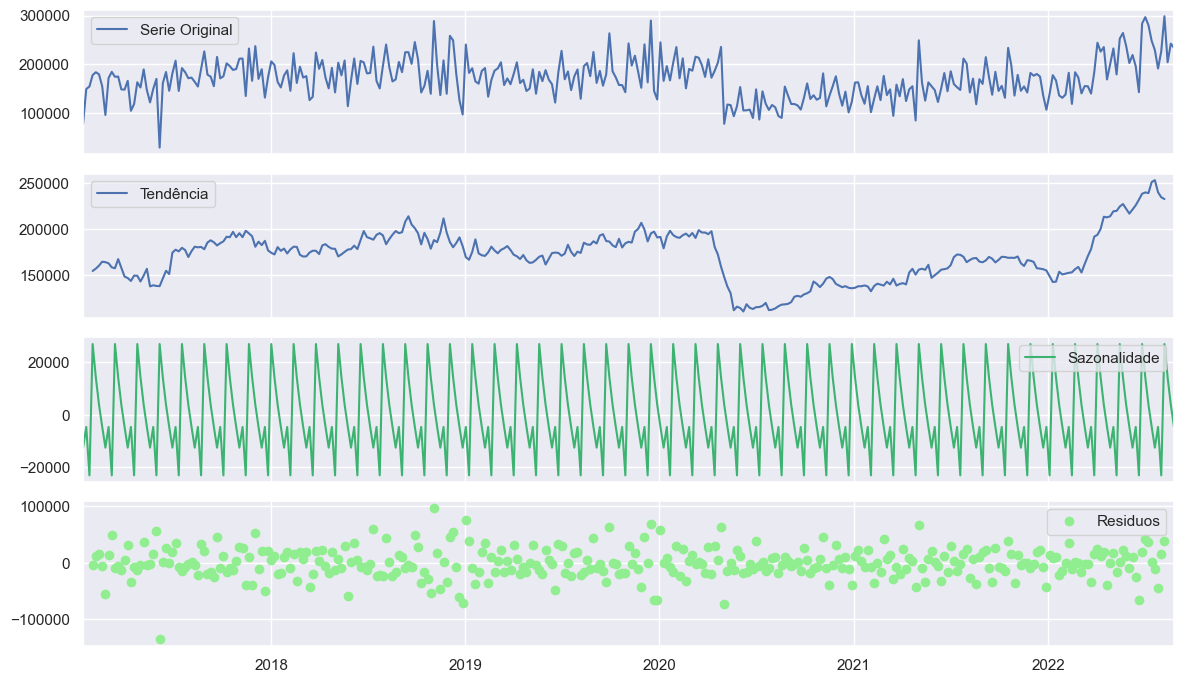

In [78]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 7))
decomposicao.observed.plot(ax=axes[0], legend='best', label='Serie Original')
decomposicao.trend.plot   (ax=axes[1], legend='best', label='Tendência')
decomposicao.seasonal.plot(ax=axes[2], legend='best', label='Sazonalidade', color='mediumseagreen')
decomposicao.resid.plot   (ax=axes[3], legend='best', label='Residuos', color='lightgreen', 
                        marker='o', linewidth=0)
plt.tight_layout();

## **Normalidade e Transformação**

### Normalidade dos dados

In [79]:
import scipy.stats as stats

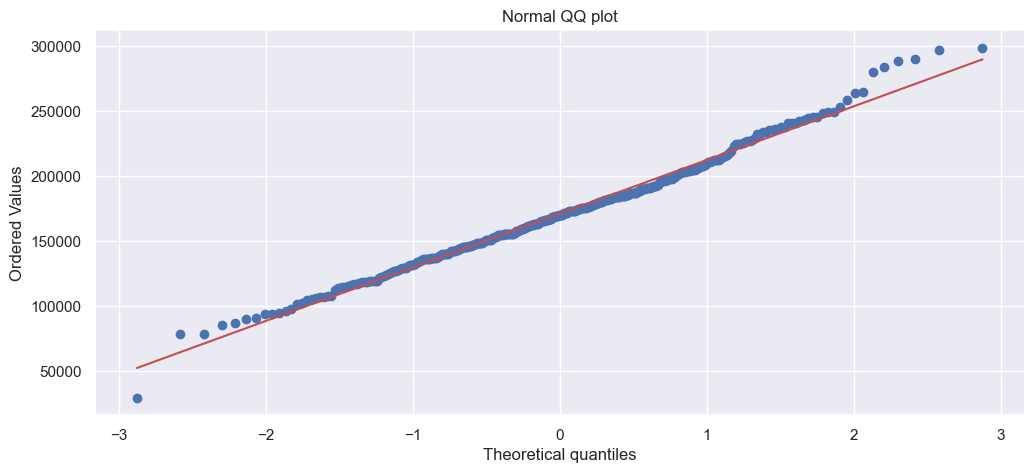

In [80]:
stats.probplot(serie, dist="norm", plot=plt)
plt.title("Normal QQ plot");

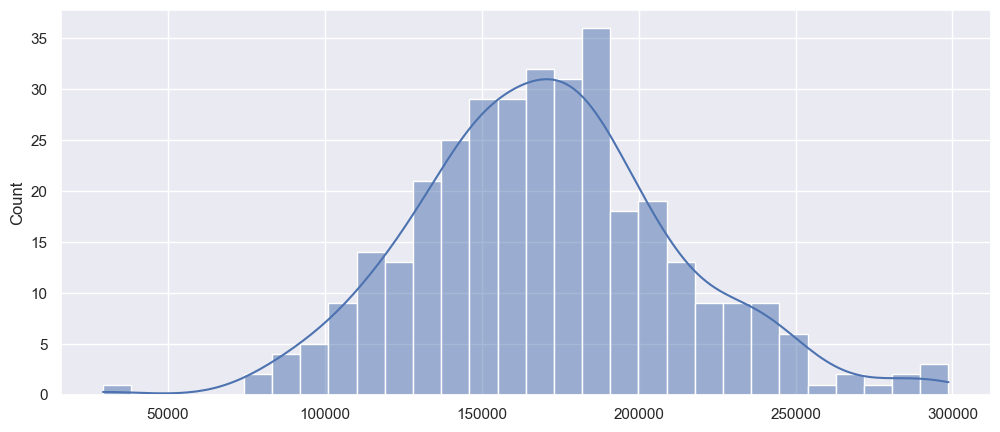

In [81]:
sns.histplot(serie, kde=True, bins=30);

#### TESTE DE SHAPIRO WILK:
    •	Critérios:
    
    Nível de Significância de 0,05 ou 5% (Mais Utilizado)
    Quando P-valor > 0,05 (Temos uma distribuição normal)
    Quando P-valor < 0,05 (Distribuição Não Normal)

In [82]:
e, p = stats.shapiro(serie)
print('Estatística de teste: {:.5f}'.format(e))
print('p-valor: {:.5f}'.format(p))

Estatística de teste: 0.99052
p-valor: 0.02608


### **Teste df (Dickey Fuller)**

    Ho = Não e Estacionario: Estatistica do teste > valor critico
    Ha = E Estacionario: Estatistica do Teste < valor critico

In [83]:
import statsmodels.tsa.stattools

In [84]:
db = statsmodels.tsa.stattools.adfuller(serie)
print(f'Estatistica do teste: {db[0]}')
print(f'P-valor: {db[1]}')
print('Valores criticos: ')
for chave, valor in db[4].items():
    print(f'{chave:<12}: {valor}')

Estatistica do teste: -2.4277052308540306
P-valor: 0.13406899276213347
Valores criticos: 
1%          : -3.450632157720528
5%          : -2.870474482366864
10%         : -2.5715301325443787


### **Transformação por BoxCox**

In [85]:
# Import das Bibliotecas Necessarias
from scipy.special import boxcox, inv_boxcox
from scipy.stats   import boxcox

In [86]:
# Criando e Transformando com Boxcox
serie_box, lam = boxcox(serie.values)
print(f'Lambda: {lam}')

Lambda: 0.762682369279349


In [87]:
# Visualização da serie e o tipo
print(type(serie_box))
serie_box[:10]

<class 'numpy.ndarray'>


array([ 7074.4534738 , 11590.34166816, 11895.35248454, 13246.8858163 ,
       13577.21204044, 13333.08551354, 11912.2446165 ,  8282.24358598,
       12909.28285919, 13620.75563163])

In [88]:
# Transformando em Serie
transform = list(serie_box.flatten())
serie_box = pd.Series(transform, index=serie.index)
serie_box

2017-01-12     7074.453474
2017-01-18    11590.341668
2017-01-24    11895.352485
2017-01-30    13246.885816
2017-02-05    13577.212040
                  ...     
2022-08-02    15933.295955
2022-08-08    19656.932697
2022-08-14    14717.605285
2022-08-20    16764.052885
2022-08-26    16319.181379
Length: 343, dtype: float64

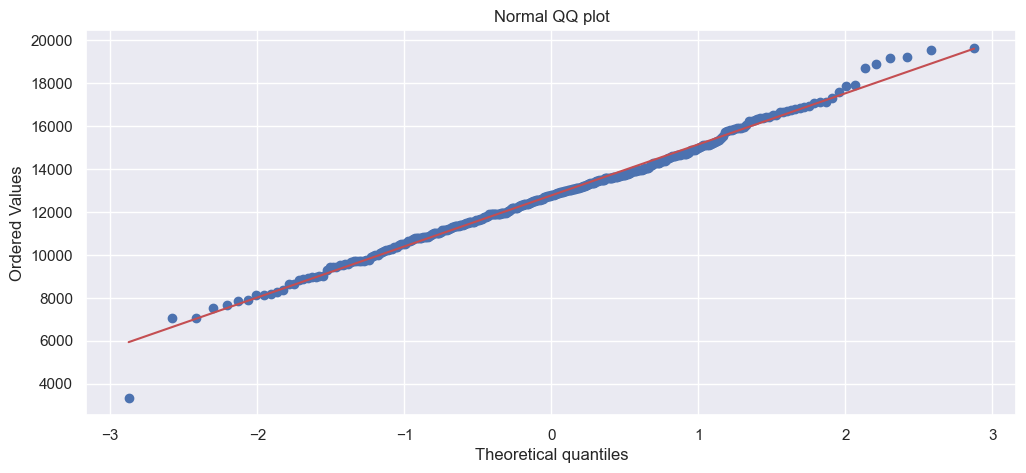

In [89]:
stats.probplot(serie_box, dist="norm", plot=plt)
plt.title("Normal QQ plot");

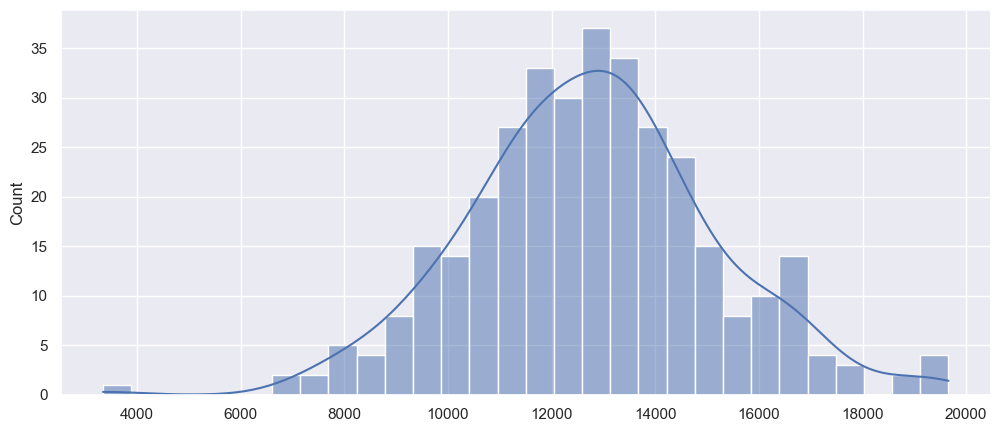

In [90]:
sns.histplot(serie_box, kde=True, bins=30);

#### TESTE DE SHAPIRO WILK:
    •	Critérios:
    
    Nível de Significância de 0,05 ou 5% (Mais Utilizado)
    Quando P-valor > 0,05 (Temos uma distribuição normal)
    Quando P-valor < 0,05 (Distribuição Não Normal)

In [91]:
# TESTE DE SHAPIRO
e, p =stats.shapiro(serie_box)
print('Estatística de teste: {:.7f}'.format(e))
print('p-valor: {:.7f}'.format(p))

Estatística de teste: 0.9931507
p-valor: 0.1202043


### **Teste df (Dickey Fuller)**

    Ho = Não e Estacionario: Estatistica do teste > valor critico
    Ha = E Estacionario: Estatistica do Teste < valor critico

In [92]:
dfb = statsmodels.tsa.stattools.adfuller(serie_box)
print(f'Estatistica do teste: {dfb[0]}')
print(f'P-valor: {dfb[1]}')
print('Valores criticos: ')
for chave, valor in dfb[4].items():
    print(f'{chave:<12}: {valor}')

Estatistica do teste: -2.459018094707276
P-valor: 0.1257666581700171
Valores criticos: 
1%          : -3.450632157720528
5%          : -2.870474482366864
10%         : -2.5715301325443787


### **Estacionaridade**

### Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

Ho Hipotese Nula = não é estacionário: estatística do teste > valor crítico

Ha Hipotese Alternativa = é estacionário:  estatística do teste < valor crítico

In [93]:
kpss = statsmodels.tsa.stattools.kpss(serie)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
   print(f'{chave:<12}: {valor}')

Estatítica do teste: 0.2709
p_valor: 0.1000
Valores Críticos:
10%         : 0.347
5%          : 0.463
2.5%        : 0.574
1%          : 0.739


In [94]:
kpss = statsmodels.tsa.stattools.kpss(serie_box)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
    print(f'{chave:<12}: {valor}')

Estatítica do teste: 0.2759
p_valor: 0.1000
Valores Críticos:
10%         : 0.347
5%          : 0.463
2.5%        : 0.574
1%          : 0.739


### **Autocorrelação**

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

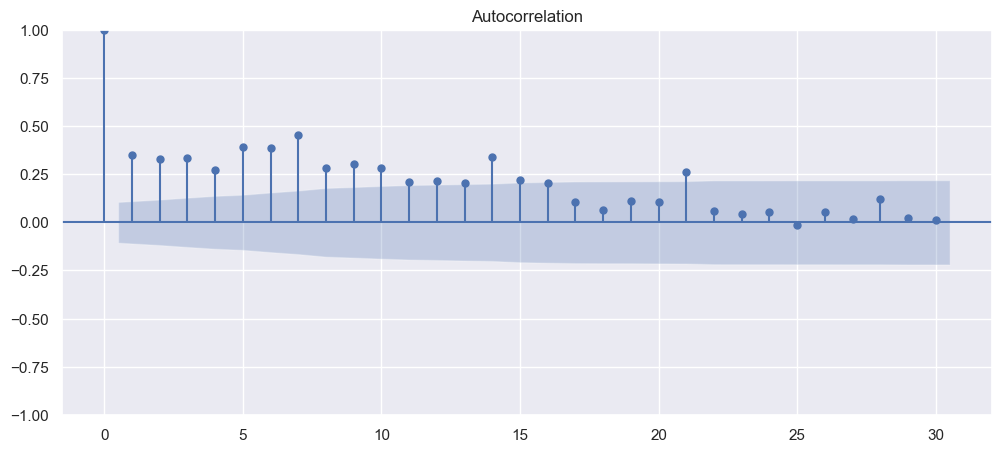

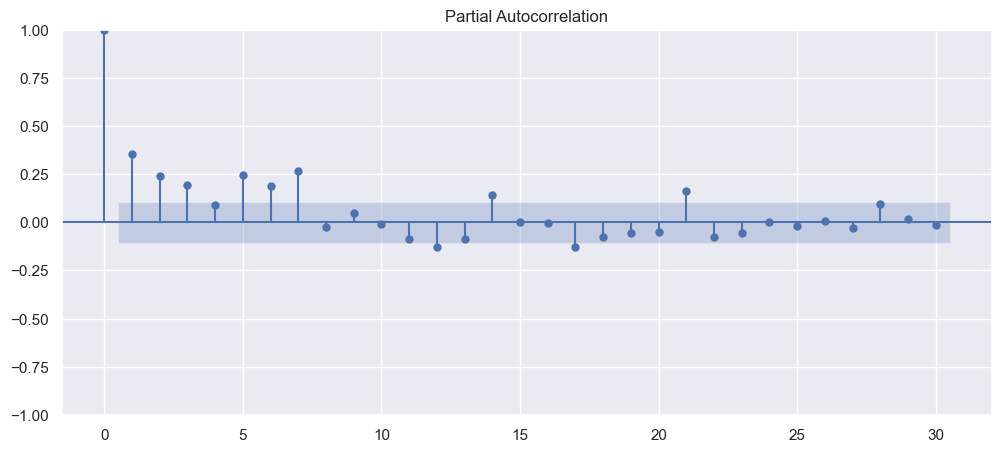

In [96]:
plot_acf(serie_box, lags=30)
plot_pacf(serie_box, lags=30);

## **Seperação Dados de Treino e Teste: SARIMA e SARIMAX**

In [97]:
#70% Treino, 30% Teste
print(f'Shape da Serie: {serie_box.shape}')
treino    = int(len(serie_box) * 0.7)
teste     = int(len(serie_box) - treino)
treino_df = serie_box[:treino]
treino_db = pd.DataFrame(treino_df, columns=['Treino'])
teste_df  = serie_box[-teste:]
teste_db  = pd.DataFrame(teste_df, columns=['Teste'])
print(f'Dados de Treino: {treino_df.shape}')
print(f'Dados te teste: {teste_df.shape}')

Shape da Serie: (343,)
Dados de Treino: (240,)
Dados te teste: (103,)


In [98]:
train_test = pd.concat([treino_db, teste_db])
fig = px.line(train_test, title='Dados de Treino e Teste', height=550)
fig.update_xaxes(rangeslider_visible=False)
fig.show()

## **MODELO AUTO-ARIMA**

#### Modelo Auto-Arima, leva em Consideração a Sazonalidade dos dados

Modelo arima:(p,d,q)

Modelo SARIMA: (p,d,q)(P,D,Q)

In [99]:
# import da biblioteca
from pmdarima.arima import auto_arima

In [100]:
#%%time 
modelo_auto = auto_arima(teste_df, exogenous=treino_df, trace=True, stepwise=False, seasonal=True, max_p=10, max_q=10, max_P=4, 
            max_Q=4, start_p=0, start_q=0, start_P=0, start_Q=0, m=7, d=1, D=1, error_action='ignore',suppress_warnings=True)
print('Resultado AIC = ', modelo_auto.aic())
# Trace: apresenta no console a lista dos modelos.
# stepwise: seleção gradual(processo mais rápido, porém menos minucioso).
# m: período sazonal
# Interessante dobrar as ordens máximas: max.p = 10, max.q = 10, max.P = 4, max.Q = 4

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1776.027, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1735.532, Time=0.32 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,1,3)[7]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,1,4)[7]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=1752.269, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,0)(1,1,3)[7]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(1,1,4)[7]             : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1747.178, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(2,1,3)[7]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=1745.514, Time=0.70 sec
 ARIMA(0,1,0)(3,1,1)[7]             : AIC=inf, Time=1.66 sec

In [101]:
#resultado_auto= modelo_auto.fit(teste_df)
print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  103
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -844.754
Date:                             Thu, 03 Nov 2022   AIC                           1701.508
Time:                                     14:44:05   BIC                           1716.831
Sample:                                 12-22-2020   HQIC                          1707.700
                                      - 08-26-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6828      0.090     -7.584      0.000      -0.859      -0.506
ar.L2         -0.4806      

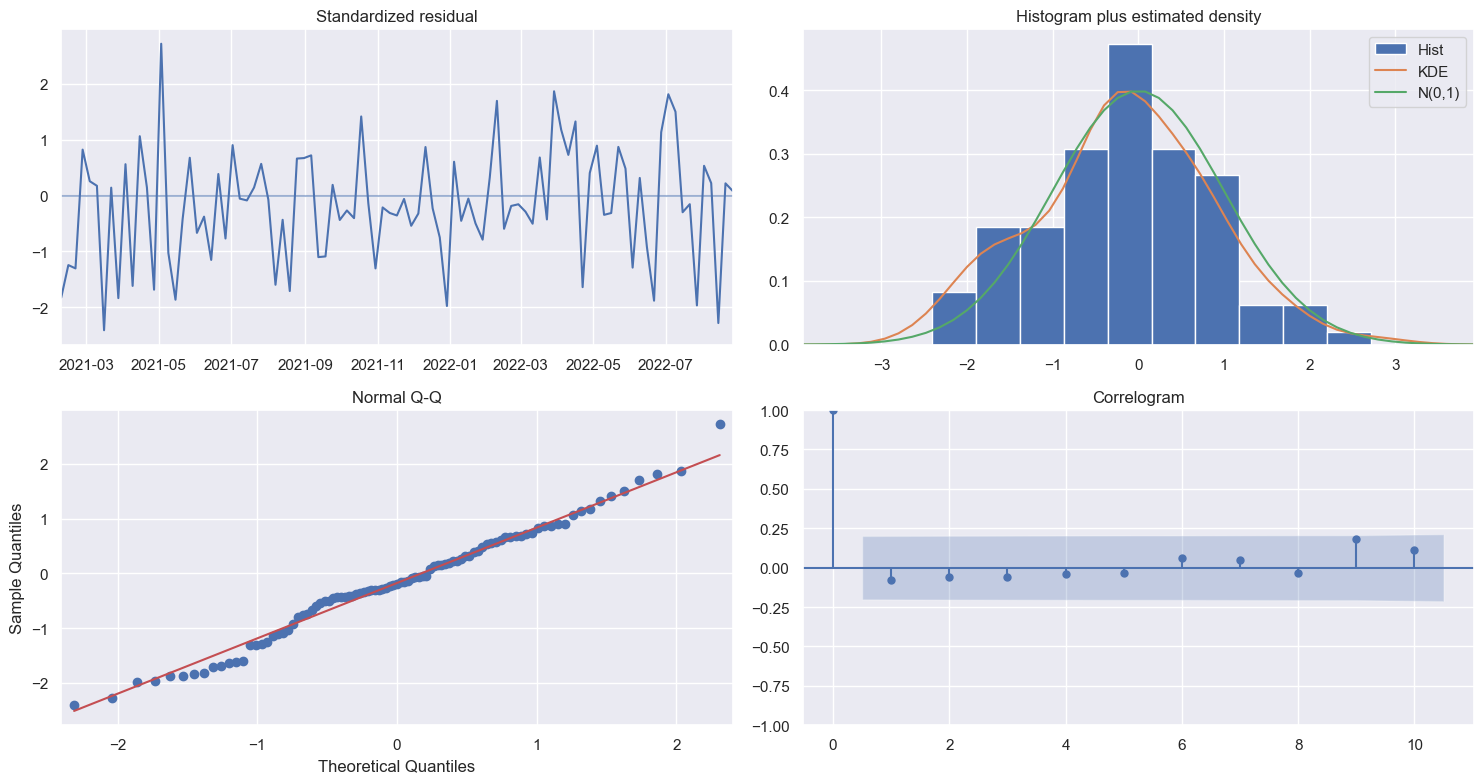

In [102]:
modelo_auto.plot_diagnostics(figsize=(15,8))
plt.tight_layout();

### **Análise dos Resíduos**

In [103]:
# Residuos
residuos_auto = modelo_auto.resid

In [104]:
# TESTE DE SHAPIRO
e, p = stats.shapiro(residuos_auto())
print('Estatística de teste: {:.5f}'.format(e))
print('p-valor: {:.5f}'.format(p))

Estatística de teste: 0.95408
p-valor: 0.00128


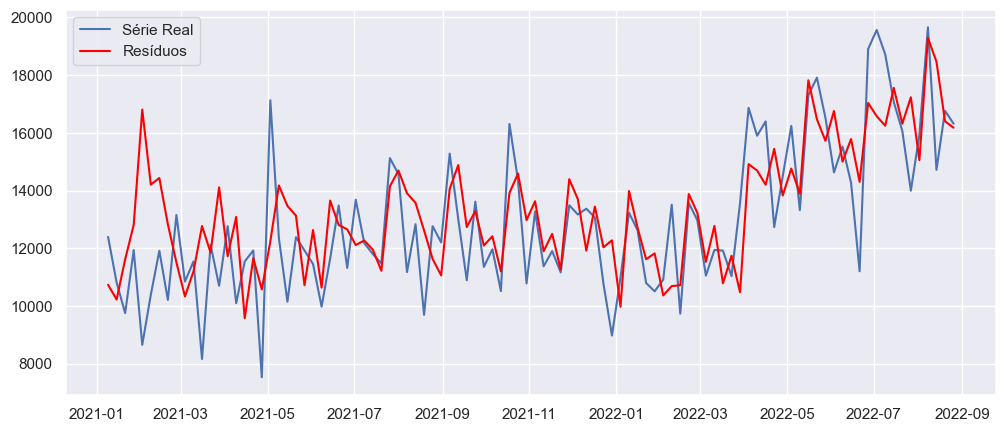

In [105]:
plt.figure(figsize=(12, 5))
plt.plot(serie_box[-100:], label='Série Real')
plt.plot(serie_box[-100:] - residuos_auto(),color='red', label='Resíduos')
plt.legend(loc='best');

### **Previsao SARIMA**

In [106]:
# Prevendo 16 Semanas
previsao_auto = modelo_auto.predict(n_periods=20)
previsao_auto = inv_boxcox(previsao_auto, lam)

# Criando o indice Data
indice = pd.date_range('2022-08-31', periods=len(previsao_auto), freq='6D')

# Criando uma nova serie
aut_arima = pd.Series(previsao_auto.values, index=indice )

In [107]:
# Criando o DataFrame
prev_auto_arima = pd.DataFrame(aut_arima, columns=['SARIMA'])
# Concatenando os dados
prever_auto_arima = pd.concat([serie[-210:], prev_auto_arima])

# Visualização Grafica periodo de 2022
fig = px.line(prever_auto_arima, title='Previsão Proximos 30 Dias com SARIMA', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## **Modelo SARIMAX**

In [108]:
# Import da Biblioteca
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Parametros SARIMA**

    Best model:  ARIMA(4,1,0)(0,1,1)[7]          
    Total fit time: 114.617 seconds
    Resultado AIC =  1701.508235889644

In [109]:
modelo_sarimax = SARIMAX(teste_df, exogenous=treino_df, order=(4, 1, 0), seasonal_order=(0, 1, 1, 7),
                        enforce_invertibility=False, enforce_stationarity=False)
# Treinando
resultado_sarimax = modelo_sarimax.fit()
# Print do Sumario
print(resultado_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  103
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -769.679
Date:                             Thu, 03 Nov 2022   AIC                           1551.357
Time:                                     14:44:10   BIC                           1566.153
Sample:                                 12-22-2020   HQIC                          1557.315
                                      - 08-26-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7587      0.112     -6.797      0.000      -0.977      -0.540
ar.L2         -0.5757      

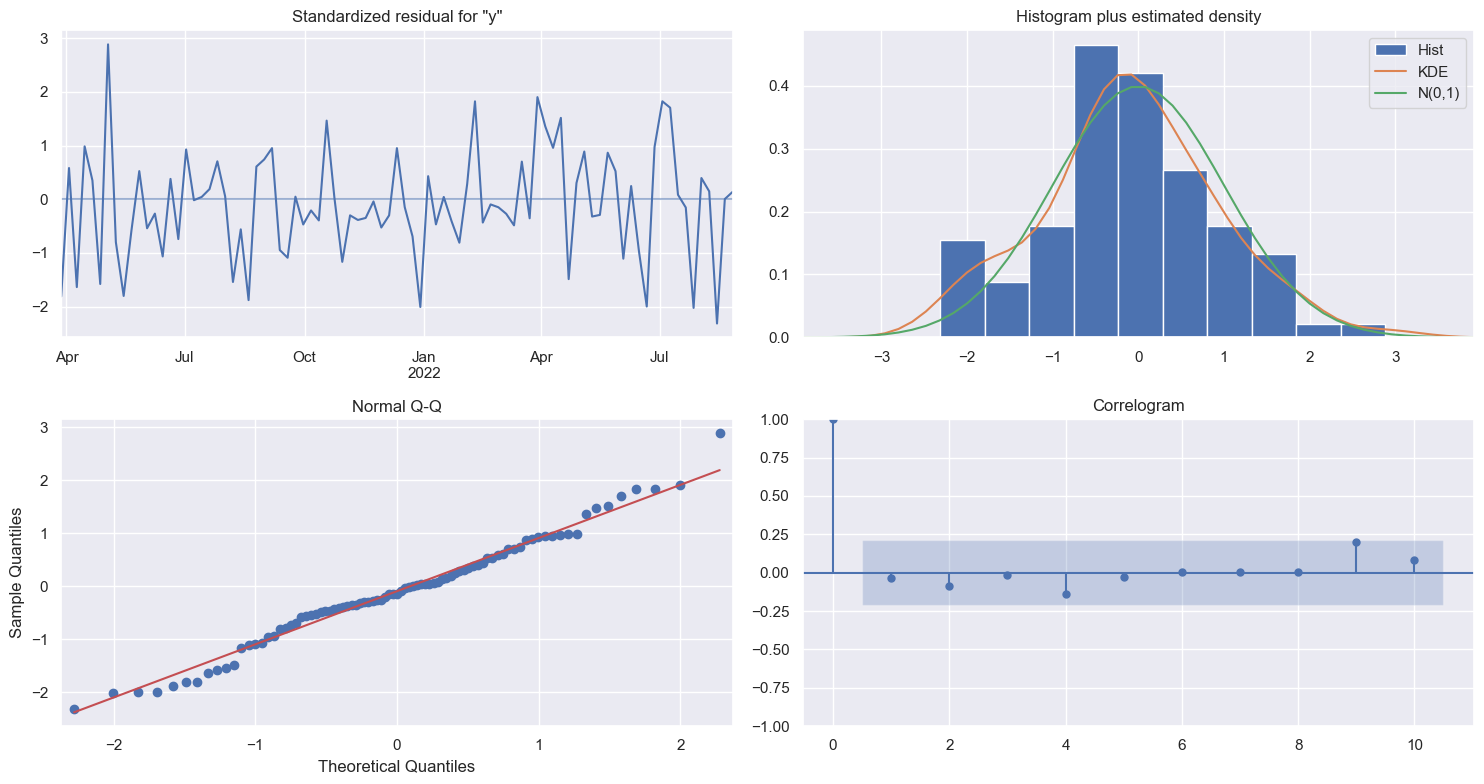

In [110]:
resultado_sarimax.plot_diagnostics(figsize=(15,8))
plt.tight_layout();

### **Análise dos Resíduos**

In [111]:
residuos_sarimax = resultado_sarimax.resid

In [112]:
# TESTE DE SHAPIRO
e, p = stats.shapiro(residuos_sarimax)
print('Estatística de teste: {:.5f}'.format(e))
print('p-valor: {:.5f}'.format(p))

Estatística de teste: 0.95536
p-valor: 0.00157


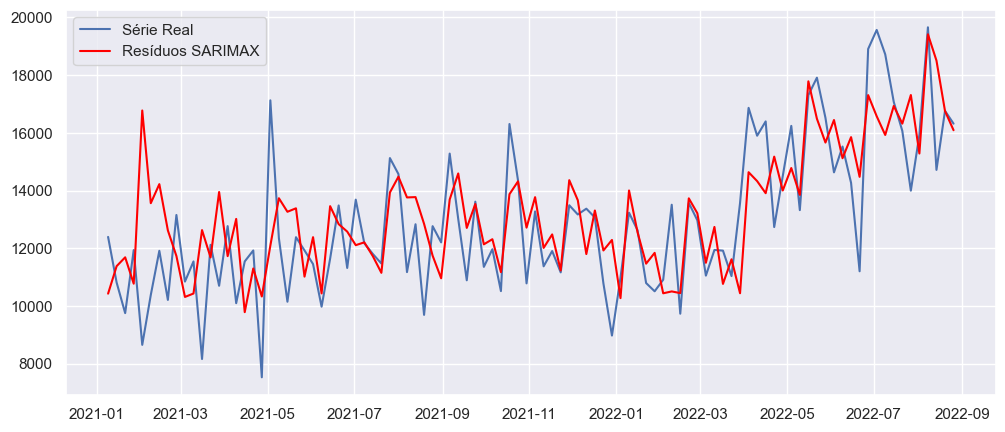

In [113]:
plt.figure(figsize=(12, 5))
plt.plot(serie_box[-100:],  color='b', label='Série Real')
plt.plot(serie_box[-100:] - residuos_sarimax,color='red', label='Resíduos SARIMAX')
plt.legend(loc='best');

### **Previsao com SARIMAX**

In [114]:
# Previsão 16 Semanas
previsao_sarimax = resultado_sarimax.forecast(20)
previsao_sarimax = inv_boxcox(previsao_sarimax, lam)

# Criando o indice Data
indice_sx = pd.date_range('2022-08-31', periods=len(previsao_sarimax), freq='6D')

# Criando uma nova serie
serie_sx = pd.Series(previsao_sarimax.values, index=indice_sx )

In [115]:
# Criando o DataFrame
prev_auto_sarimax = pd.DataFrame(serie_sx, columns=['SARIMAX'])
# Concatenando os dados
prever_sarimax = pd.concat([serie[-210:], prev_auto_sarimax])

# Visualização Graficoa Periodo de 2022
fig = px.line(prever_sarimax, title='Previsão Proximas 20 Semanas com SARIMAX', height=600)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# ANALISE DO MELHOR MODELO 

### SARIMA: Leva em consideração a Sazonalidade

                         SARIMAX Results                                      
    ===========================================================================================
    Dep. Variable:                                   y   No. Observations:                  103
    Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -844.754
    Date:                             Thu, 03 Nov 2022   AIC                           1701.508
    Time:                                     10:45:20   BIC                           1716.831
    Sample:                                 12-22-2020   HQIC                          1707.700

### SARIMAX

                           SARIMAX Results                                      
    ===========================================================================================
    Dep. Variable:                                   y   No. Observations:                  103
    Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -769.679
    Date:                             Thu, 03 Nov 2022   AIC                           1551.357
    Time:                                     10:46:13   BIC                           1566.153
    Sample:                                 12-22-2020   HQIC                          1557.315

# **Análise Final do Projeto**

    ANALISE DO MELHOR MODELO SARIMAX
    COMPARAÇÃO COM PERIODOS ANTERIORES E DESEMPENHO

In [116]:
# Utilizando 8 Semanas periodos para Analise e Desempenho do Modelo
valores = 8
previsao_passada = resultado_sarimax.predict(len(teste_df)- len(teste_df[-valores:])+1, end=len(teste_df))
previsao_futura  = resultado_sarimax.forecast(valores)
deste_box        = serie_box[-valores:].values

In [117]:
auto_arima    = modelo_auto.predict(n_periods=valores)
previsao_auto = inv_boxcox(auto_arima, lam)

In [118]:
indice_sx = pd.date_range('2022-07-05', periods=len(previsao_futura), freq='6D')

In [119]:
so = []
dados = pd.DataFrame(so)
dados['Data']            = indice_sx.values
dados['Valores_Reais']   = deste_box
dados['Modelo_Sarimax']  = previsao_passada.values
dados['Previsao_Futura'] = previsao_futura.values
dados['Auto_ARIMA']      = auto_arima.values
dados[:5]

Data  Valores_Reais  Modelo_Sarimax  Previsao_Futura    Auto_ARIMA
0 2022-07-05   17070.773169    16319.952835     15372.673118  15361.251965
1 2022-07-11   16068.341071    17310.856372     15793.391806  16083.066080
2 2022-07-17   13998.097067    15284.900866     14296.001151  14452.506000
3 2022-07-23   15933.295955    19415.173637     18709.658993  18684.425653
4 2022-07-29   19656.932697    18504.385990     17783.831924  17901.792790

In [120]:
serie_real   = inv_boxcox(deste_box, lam) 
serie_real   = list(serie_real.flatten())

In [121]:
# Dados com a transformação por BoxCox
previsao_p   = inv_boxcox(previsao_passada, lam)
previsao_f   = inv_boxcox(previsao_futura, lam)
# Criando o DataFrame
ab = []
df_real = pd.DataFrame(ab)
df_real['DATA']       = indice_sx.values
df_real['Valores_R']  = serie_real
df_real['Previsao_F'] = previsao_f.values
df_real['Previsao_P'] = previsao_p.values
df_real['P_Auto_arima'] = previsao_auto.values

In [122]:
df_real = df_real.round(2)
df_real[:5]

DATA  Valores_R  Previsao_F  Previsao_P  P_Auto_arima
0 2022-07-05  248282.48   216415.35   234064.46     216204.58
1 2022-07-11  229344.67   224213.35   252870.48     229620.26
2 2022-07-17  191405.43   196763.47   214796.79     199592.33
3 2022-07-23  226820.91   279990.38   293913.22     279495.40
4 2022-07-29  298720.79   261966.94   275969.78     264247.44

### AVALIAÇÃO DOS ERROS DO MODELO PARA FINS DE ANALISE DE DESEMPENHO

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Avaliação dos Erros Com Dados REVERTIDA A Transformação com BoxCox

In [124]:
print(f'{"*"*33}\33[33;4m{"AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM PREVISÃO FUTURA"}\33[0m{"*"*33}')
mae_sarimax =  mean_absolute_error(df_real['Valores_R'], df_real['Previsao_F'])
print(f'(MAE) Erro Médio Absoluto: {mae_sarimax:.3f}')
mse_sarimax =  mean_squared_error(df_real['Valores_R'],  df_real['Previsao_F'])
print(f'(MSE) Erro Quadrático Médio: {mse_sarimax:.3f}')
rmse_sarimax = mean_squared_error(df_real['Valores_R'],  df_real['Previsao_F'], squared=False)
print(f'(RMSE) Raiz do Erro Quadrático Médio: {rmse_sarimax:.3f}')
mape_sarimax = mean_absolute_percentage_error(df_real['Valores_R'],  df_real['Previsao_F'])
print(f"(MAPE) Erro Percentual Absoluto Médio: {(mape_sarimax) * 100:.3F}")
print(f'{"-"*125}')

*********************************AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM PREVISÃO FUTURA*********************************
(MAE) Erro Médio Absoluto: 22472.950
(MSE) Erro Quadrático Médio: 854119177.178
(RMSE) Raiz do Erro Quadrático Médio: 29225.317
(MAPE) Erro Percentual Absoluto Médio: 9.540
-----------------------------------------------------------------------------------------------------------------------------


In [125]:
print(f'{"*"*33}\33[33;4m{"AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM DADOS PASSADOS"}\33[0m{"*"*33}')
mae_sarimax =  mean_absolute_error(df_real['Valores_R'], df_real['Previsao_P'])
print(f'(MAE) Erro Médio Absoluto: {mae_sarimax:.3f}')
mse_sarimax =  mean_squared_error(df_real['Valores_R'],  df_real['Previsao_P'])
print(f'(MSE) Erro Quadrático Médio: {mse_sarimax:.3f}')
rmse_sarimax = mean_squared_error(df_real['Valores_R'],  df_real['Previsao_P'], squared=False)
print(f'(RMSE) Raiz do Erro Quadrático Médio: {rmse_sarimax:.3f}')
mape_sarimax = mean_absolute_percentage_error(df_real['Valores_R'],  df_real['Previsao_P'])
print(f"(MAPE) Erro Percentual Absoluto Médio: {(mape_sarimax) * 100:.3F}")
print(f'{"-"*125}')

*********************************AVALIAÇÃO DO MODELO SARIMAX COMPARANDO COM DADOS PASSADOS*********************************
(MAE) Erro Médio Absoluto: 27396.514
(MSE) Erro Quadrático Médio: 1028681309.393
(RMSE) Raiz do Erro Quadrático Médio: 32073.062
(MAPE) Erro Percentual Absoluto Médio: 12.087
-----------------------------------------------------------------------------------------------------------------------------


### Fazendo Previsão Para os Proximos Meses

In [126]:
# Previsão Para os Proximos 4 Meses
previsao_sarimax = resultado_sarimax.forecast(21)
previsao_sarimax = inv_boxcox(previsao_sarimax, lam)
# Criando o indice Data
indice_sx = pd.date_range('2022-08-31', periods=len(previsao_sarimax), freq='6D')
# Criando uma nova serie
serie_sx = pd.Series(previsao_sarimax.values, index=indice_sx )
serie_sx2 = pd.DataFrame(serie_sx)

In [127]:
# Trazendos Os Dados Copiados no inicio do Projeto
df = dados_serie[['DATA','VR_LIQUIDO']]
df = pd.Series(df['VR_LIQUIDO'].values, index=df['DATA'].values)

In [128]:
dados_concat = pd.concat([df, serie_sx2])
dados_concat.reset_index(inplace=True)
dados_concat = dados_concat.rename(columns={'index':'DATA', 0:'VR_LIQUIDO'})
dados_concat['ANO_MES'] = dados_concat['DATA'].apply(lambda x: str(x)[:7])

## Grafico Previsao Proximos 4 Meses

In [129]:
teste = dados_concat.groupby('ANO_MES').sum()
teste.reset_index(inplace=True)
fig = px.bar(teste[45:], x='ANO_MES', y='VR_LIQUIDO', color='VR_LIQUIDO',
            title='Grafico Com os Proximos 4 Meses de Previsão', height=600,)
fig.update_xaxes(rangeslider_visible=True)
fig.show()